# Initial setup and file names

In [1]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.data_analysis.ecmwf_data_analysis import *

In [2]:
# Adapt to the Path where data is stored
os.environ["DATA_PATH"] = os.path.expanduser("./data")
base_data_path = os.getenv("DATA_PATH")

input_data_path = os.path.join(base_data_path, "input_data/")
output_data_path = os.path.join(base_data_path, "output_data/")

output_era5_file_name = "era5-ethiopia"
output_ecmwf_file_name = "ecmwf-ethiopia"


admin_file_name = os.path.join(
    "admin_boundary_eth", "eth_admbnda_adm1_csa_bofedb_2021.shp"
)
admin_code_label = "ADM1_PCODE"

# Define the months to be used in the analysis.
# Include all 12 months (by default) or a selection depending on rainy season

# month_range = range(1,13) for all months
month_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Define the list of quantile values to be used in the last part of the  analysis
quantile_value_list = [1 / 2, 1 / 3, 1 / 4, 1 / 5]

# tp_col_name indicates the column to be used for ECMWF precipitation value:
# tp_mm_day_raw for the original value, tp_mm_day_bias_corrected for the
# value after leadtime bias-correction and tp_mm_day_era5_calibrated for the
# ERA5-calibrated data.
ecmwf_tp_col_name = "tp_mm_day_bias_corrected"

In [3]:
def create_file_name(
    output_data_path,
    output_era5_file_name,
    output_ecmwf_file_name,
    admin_file_name,
    admin_code_label,
):

    global admin_boundary_file_path, ecmwf_processed_pixel_file_path, ecmwf_processed_adm_file_path, era5_processed_pixel_file_path, era5_processed_adm_file_path

    admin_boundary_file_path = input_data_path + admin_file_name
    ecmwf_processed_pixel_file_path = (
        output_data_path
        + output_ecmwf_file_name
        + "-processed-pixel"
        + ".parquet.gzip"
    )
    ecmwf_processed_adm_file_path = (
        output_data_path
        + output_ecmwf_file_name
        + "-processed-adm"
        + ".parquet.gzip"
    )
    era5_processed_pixel_file_path = (
        output_data_path
        + output_era5_file_name
        + "-processed-pixel"
        + ".parquet.gzip"
    )
    era5_processed_adm_file_path = (
        output_data_path
        + output_era5_file_name
        + "-processed-adm"
        + ".parquet.gzip"
    )

    return ()

In [4]:
create_file_name(
    output_data_path,
    output_era5_file_name,
    output_ecmwf_file_name,
    admin_file_name,
    admin_code_label,
)

()

## Load Data

In [5]:
era5_pixel_df = pd.read_parquet(era5_processed_pixel_file_path)
era5_adm_df = pd.read_parquet(era5_processed_adm_file_path)

ecmwf_pixel_df = pd.read_parquet(ecmwf_processed_pixel_file_path)
ecmwf_adm_df = pd.read_parquet(ecmwf_processed_adm_file_path)


admin_df = gpd.read_file(admin_boundary_file_path)
admin_df["adm_pcode"] = admin_df[admin_code_label]

## Compute quantile probabilities

In [6]:
ecmwf_adm_quantile_df = compute_quantile_probability(
    ecmwf_adm_df, quantile_value_list, tp_col_name=ecmwf_tp_col_name
)
era5_adm_quantile_df = compute_quantile_probability(
    era5_adm_df, quantile_value_list, tp_col_name="tp_mm_day"
)

ecmwf_pixel_quantile_df = compute_quantile_probability(
    ecmwf_pixel_df, quantile_value_list, tp_col_name=ecmwf_tp_col_name
)
era5_pixel_quantile_df = compute_quantile_probability(
    era5_pixel_df, quantile_value_list, tp_col_name="tp_mm_day"
)

## Precipitation Bias

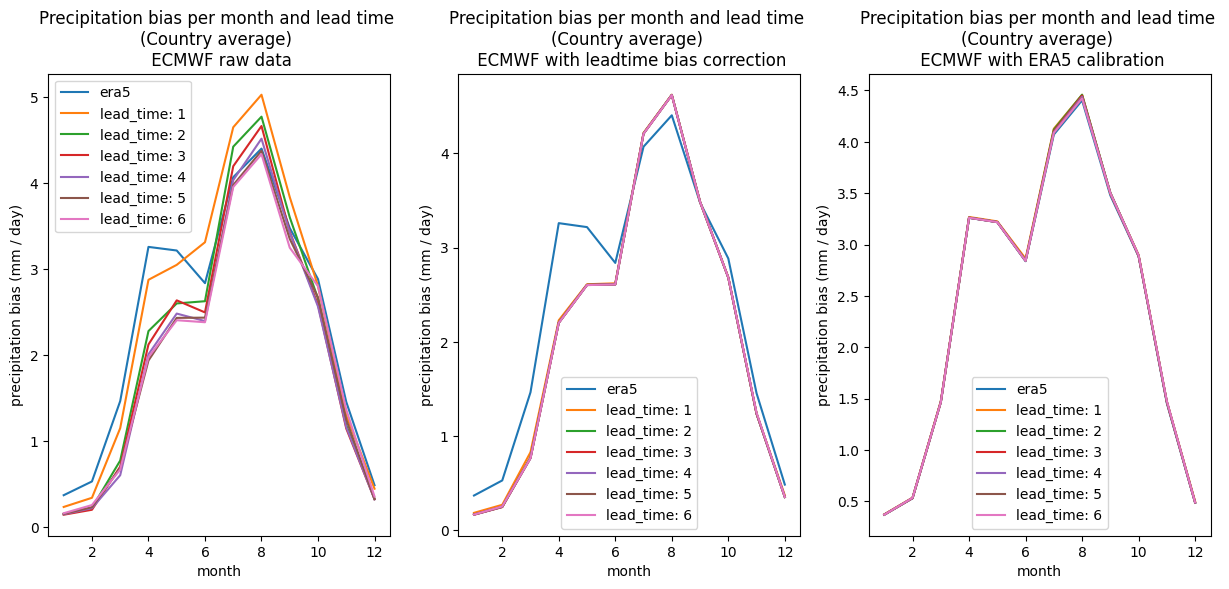

In [7]:
ecmwf_plot_df, era5_plot_df = prepare_climatology(
    ecmwf_pixel_df, era5_pixel_df
)
plot_climatology(ecmwf_plot_df, era5_plot_df, scope_text="Country average")

## Leadtime Dependency

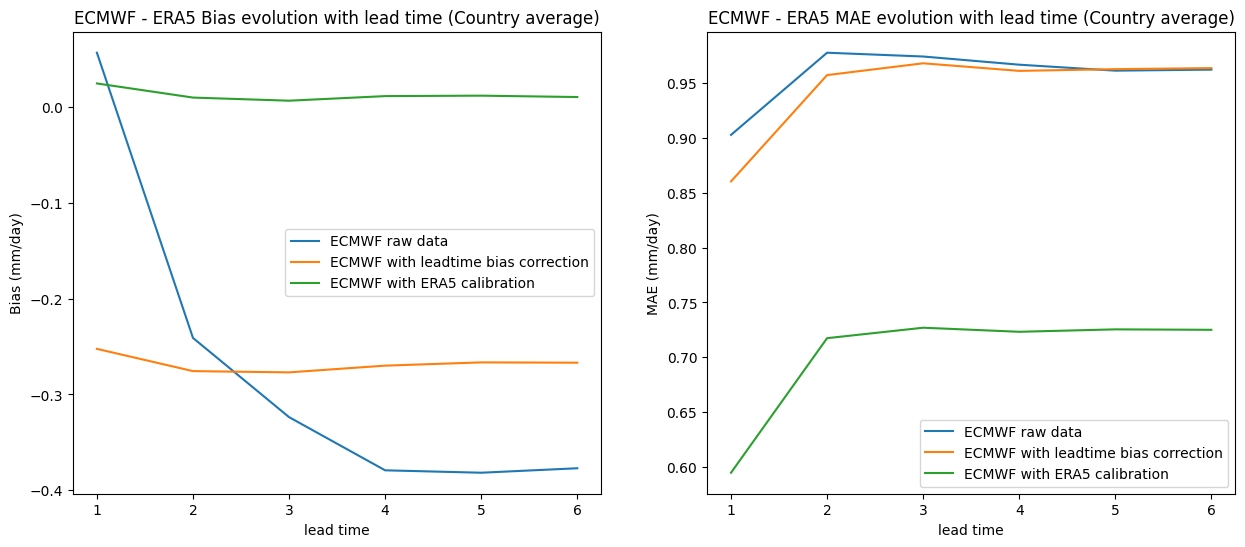

In [8]:
plot_df = prepare_leadtime_month_dependency(
    ecmwf_pixel_df, era5_pixel_df, month_range
)
plot_leadtime_month_dependency(plot_df, scope_text="Country average")

## Quantile probablity accuracy analysis

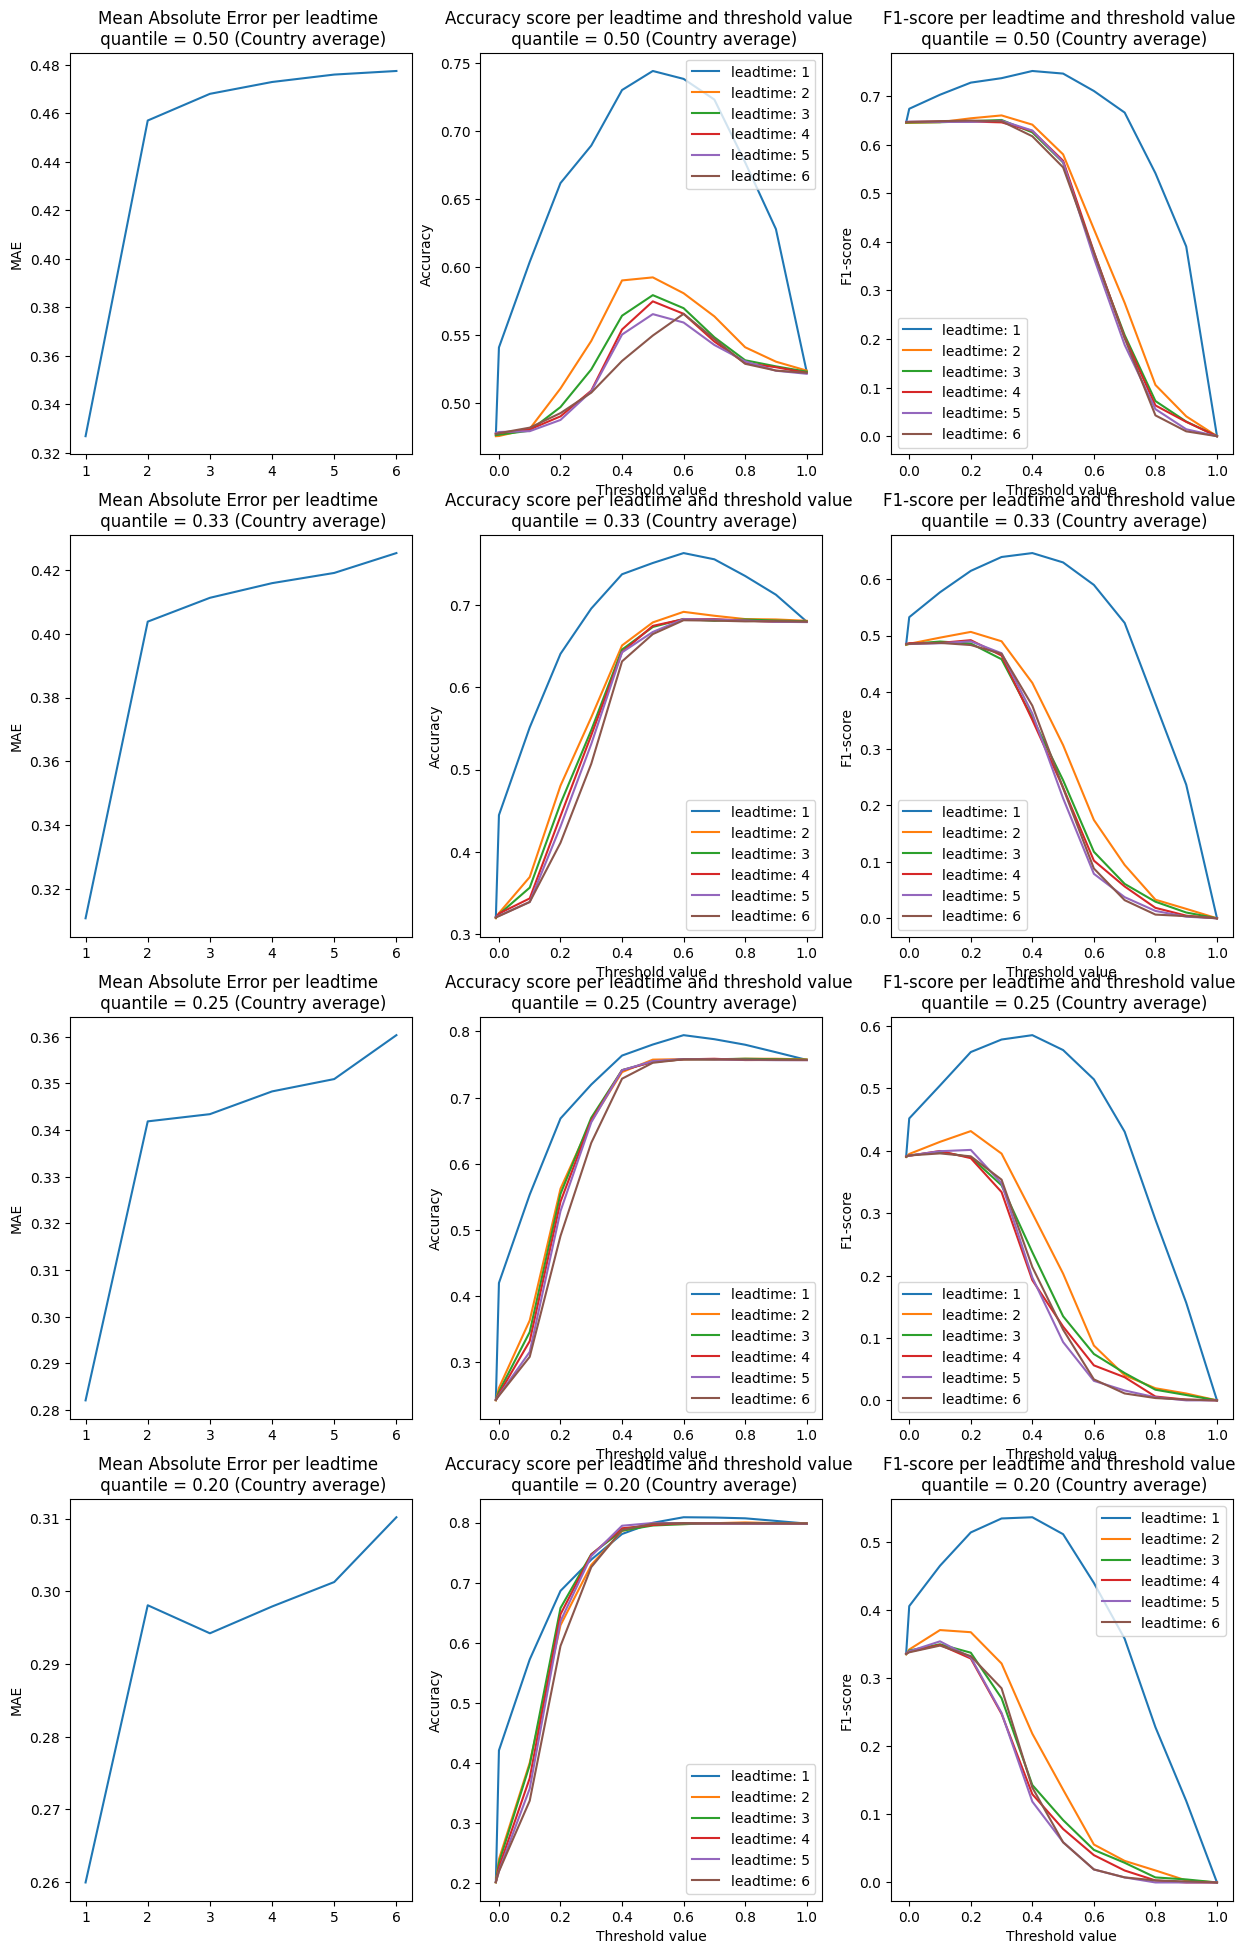

In [10]:
plot_performance_analysis(
    ecmwf_adm_quantile_df,
    era5_adm_quantile_df,
    quantile_value_list,
    month_range,
    scope_text="Country average",
)

## ROC / AUC probablity analysis

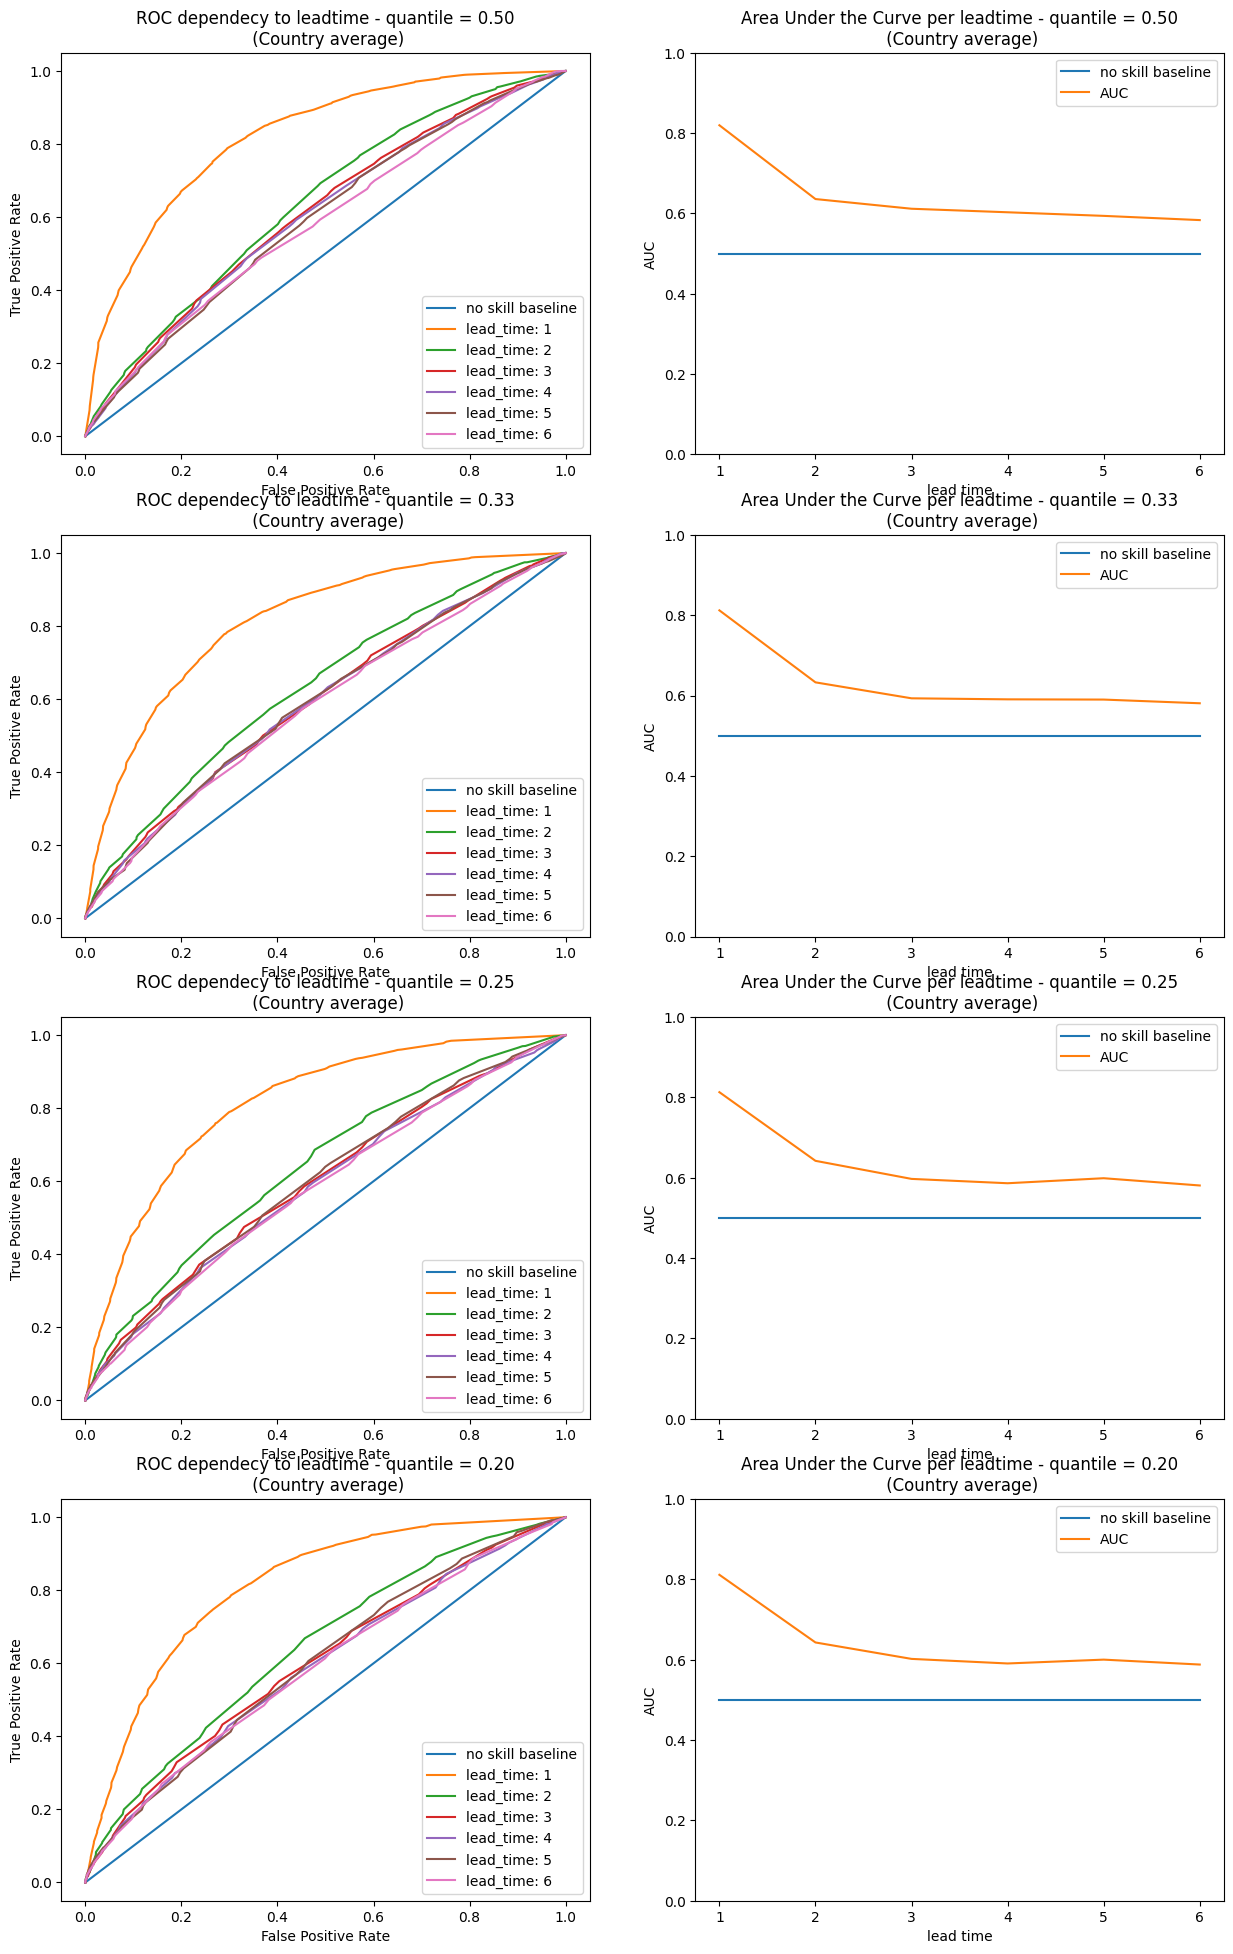

In [11]:
plot_roc_auc_analysis(
    ecmwf_adm_quantile_df,
    era5_adm_quantile_df,
    quantile_value_list,
    month_range,
    scope_text="Country average",
)

## Visualisation Sandbox

In [12]:
# Leadtime and probability threshold to be used in this spatial plot
leadtime = 1
threshold = 0.25

# Preparation for map per administrative boundary
plot_adm_df = preparece_accuracy_map(
    ecmwf_adm_quantile_df,
    era5_adm_quantile_df,
    admin_df,
    quantile_value_list,
    month_range,
    leadtime,
    threshold,
)

# Preparation for map per pixel
plot_pixel_df = preparece_accuracy_map(
    ecmwf_pixel_quantile_df,
    era5_pixel_quantile_df,
    admin_df,
    quantile_value_list,
    month_range,
    leadtime,
    threshold,
)

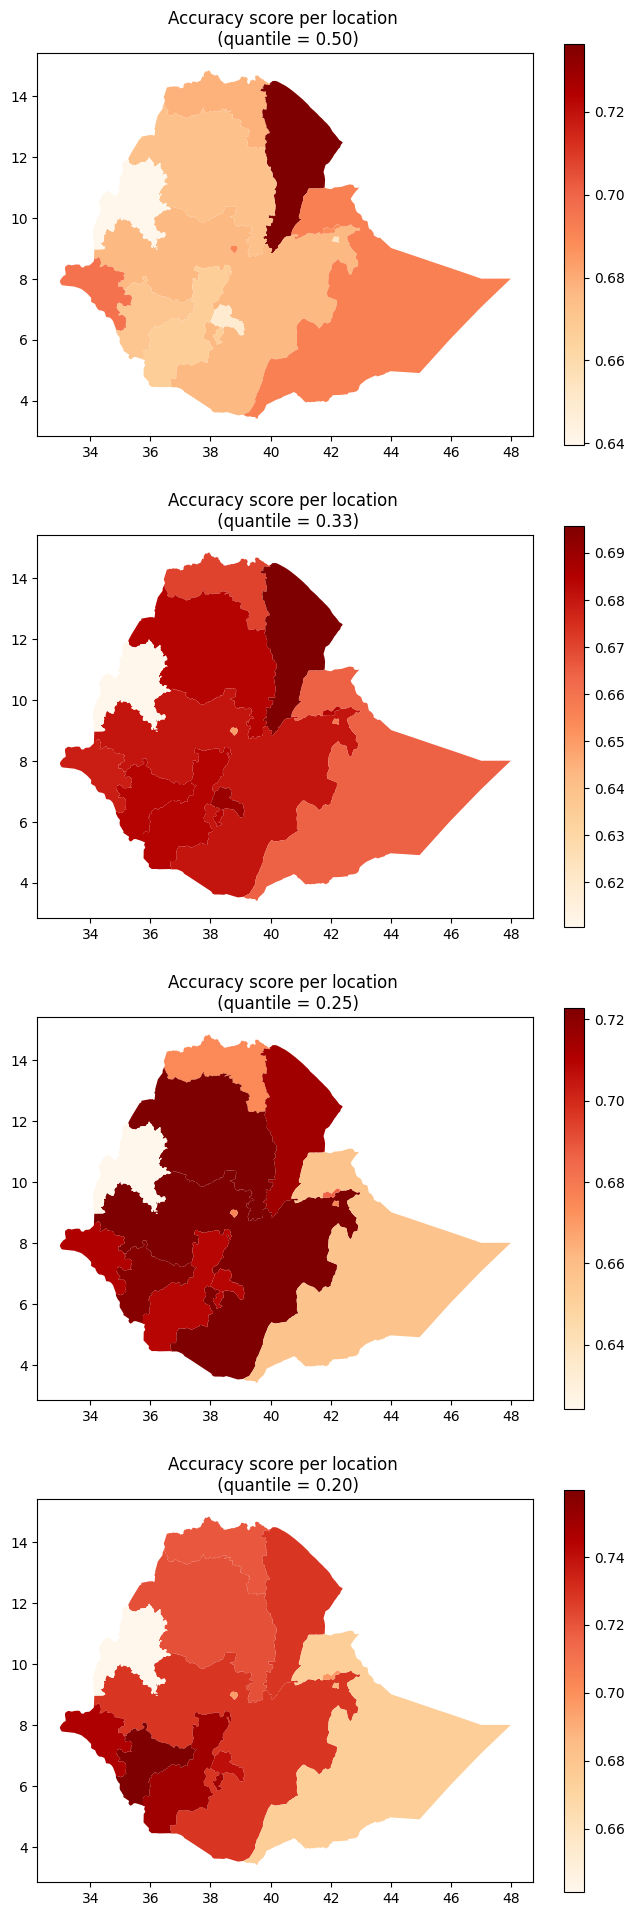

In [13]:
plot_accuracy_map(plot_adm_df, quantile_value_list)

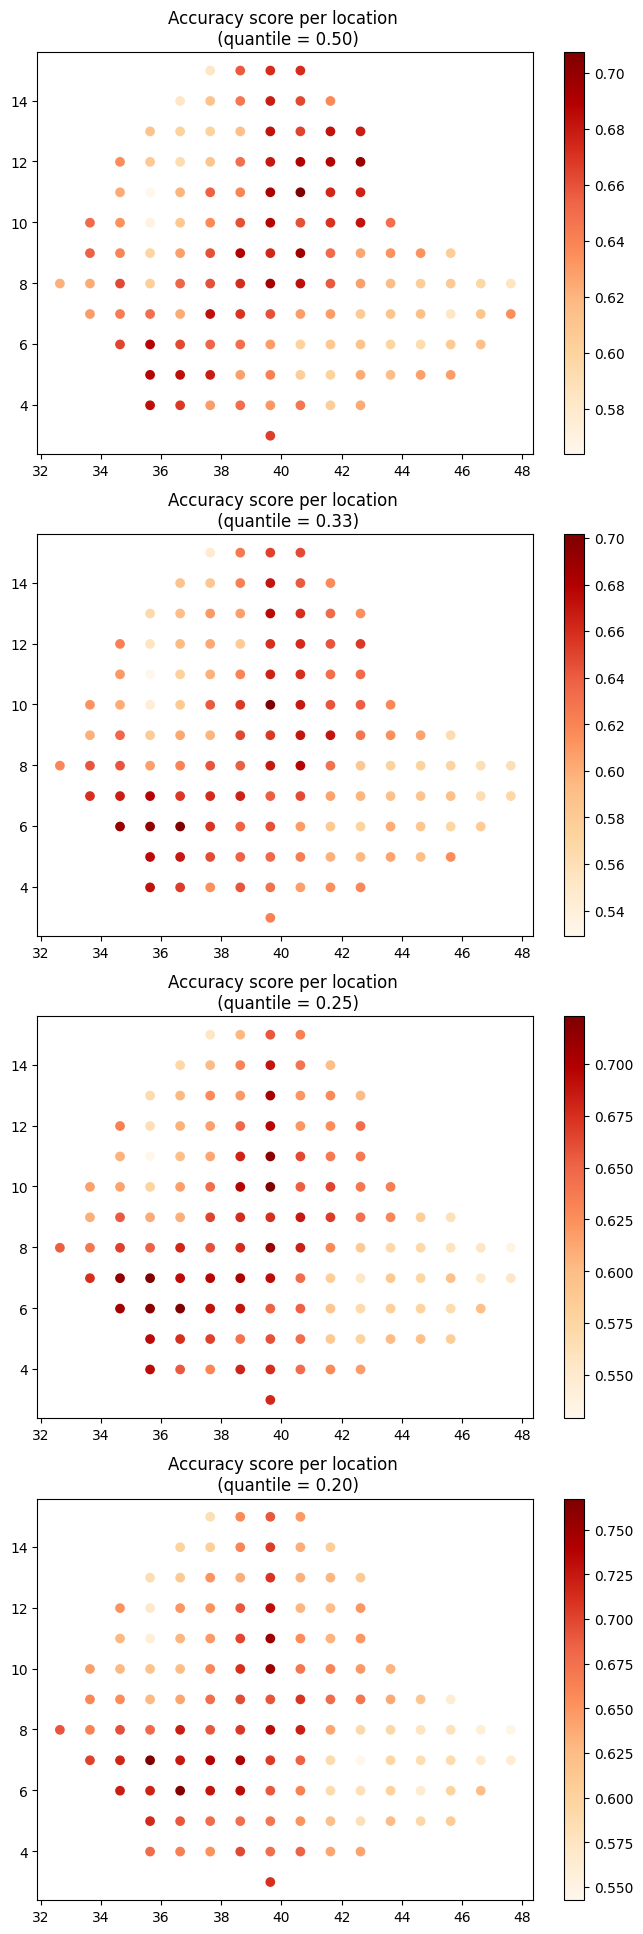

In [14]:
plot_accuracy_map(plot_pixel_df, quantile_value_list)

# Focus on sub-divisions

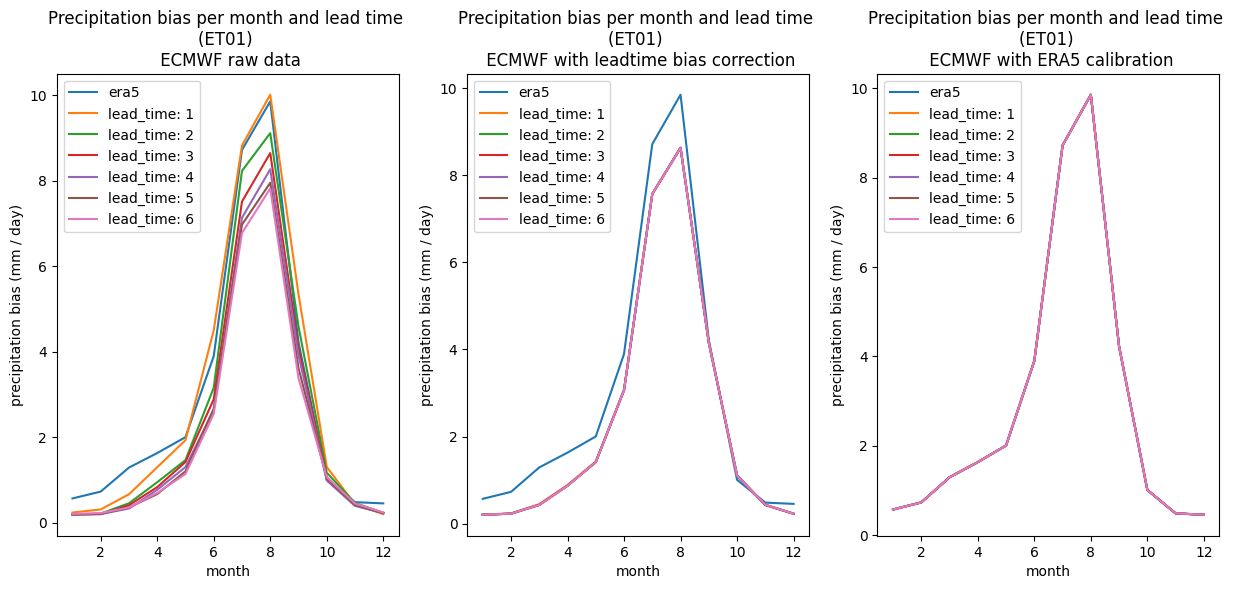

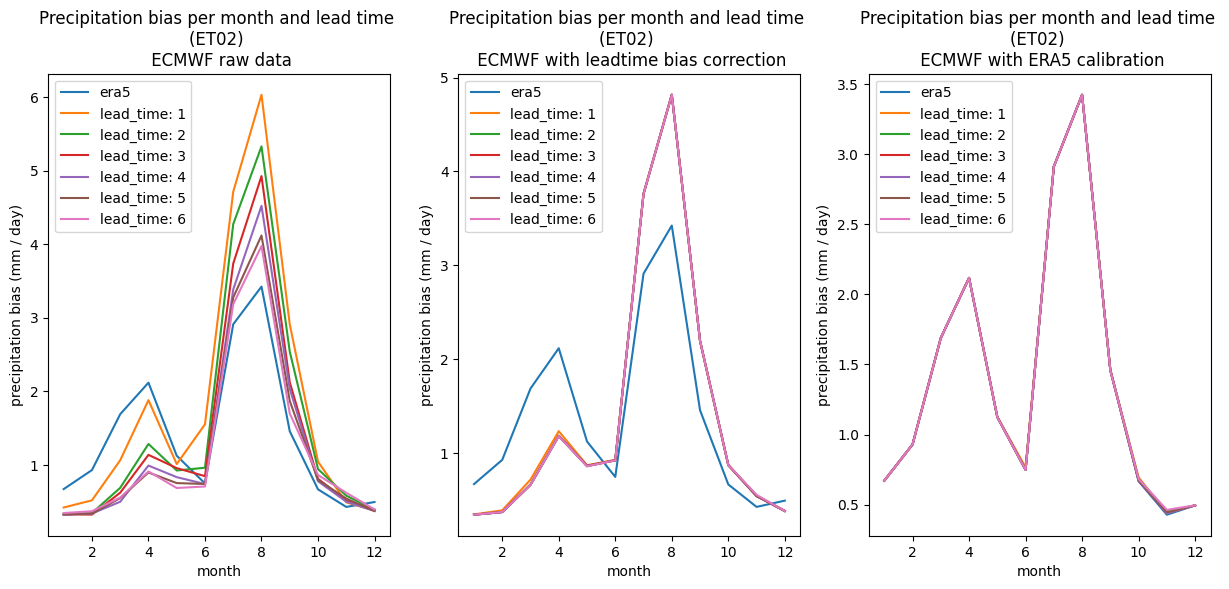

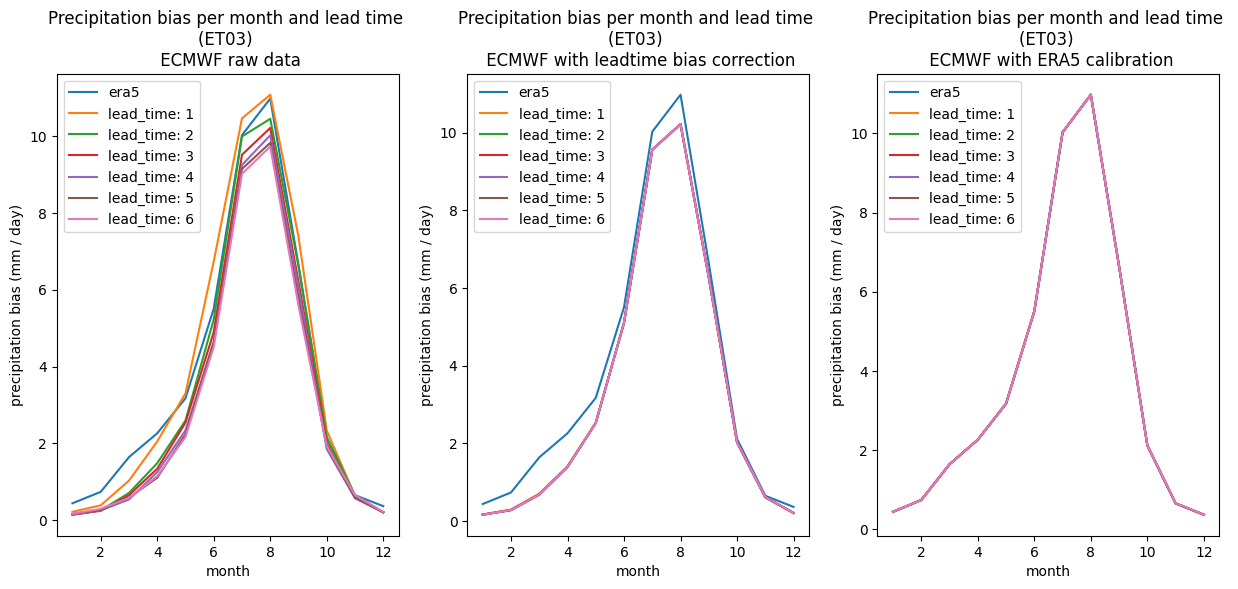

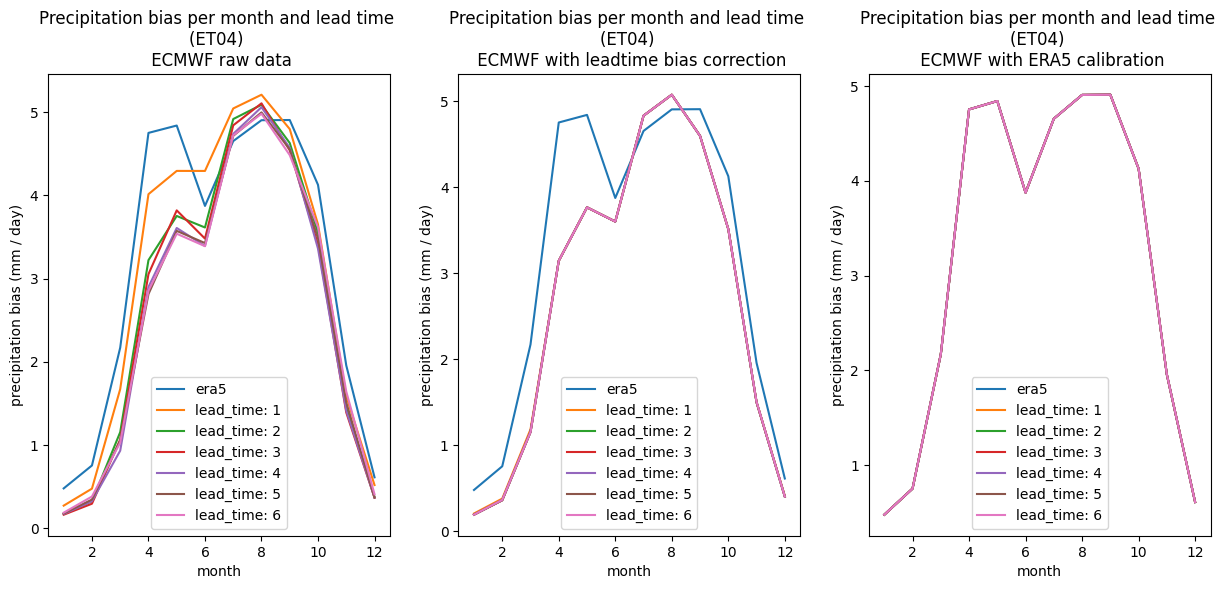

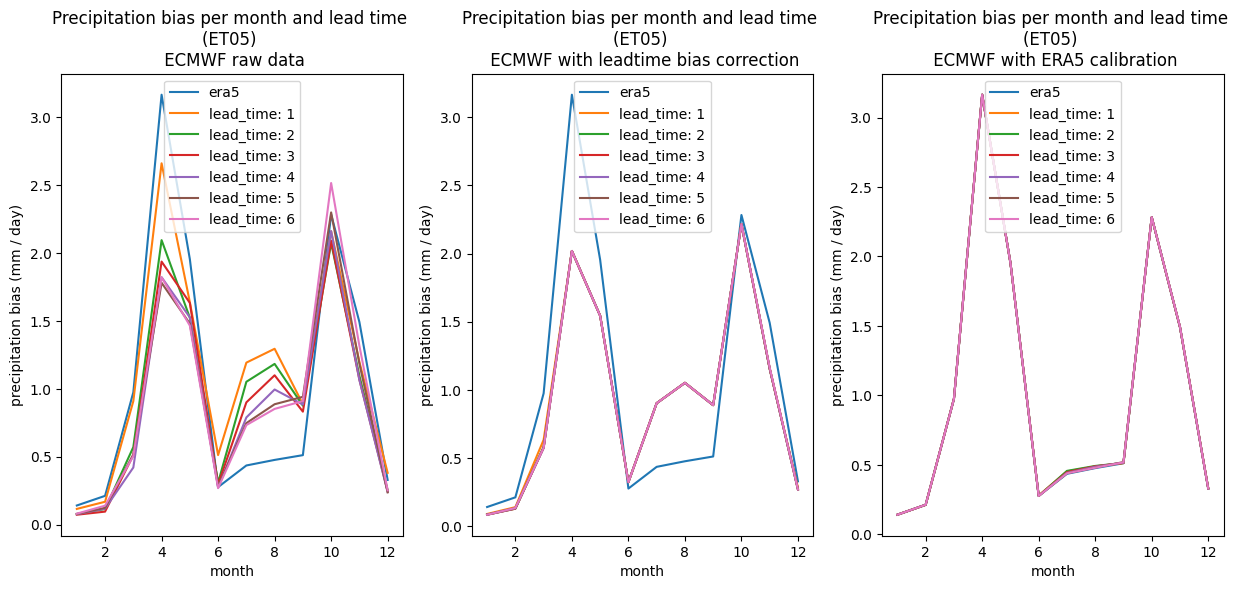

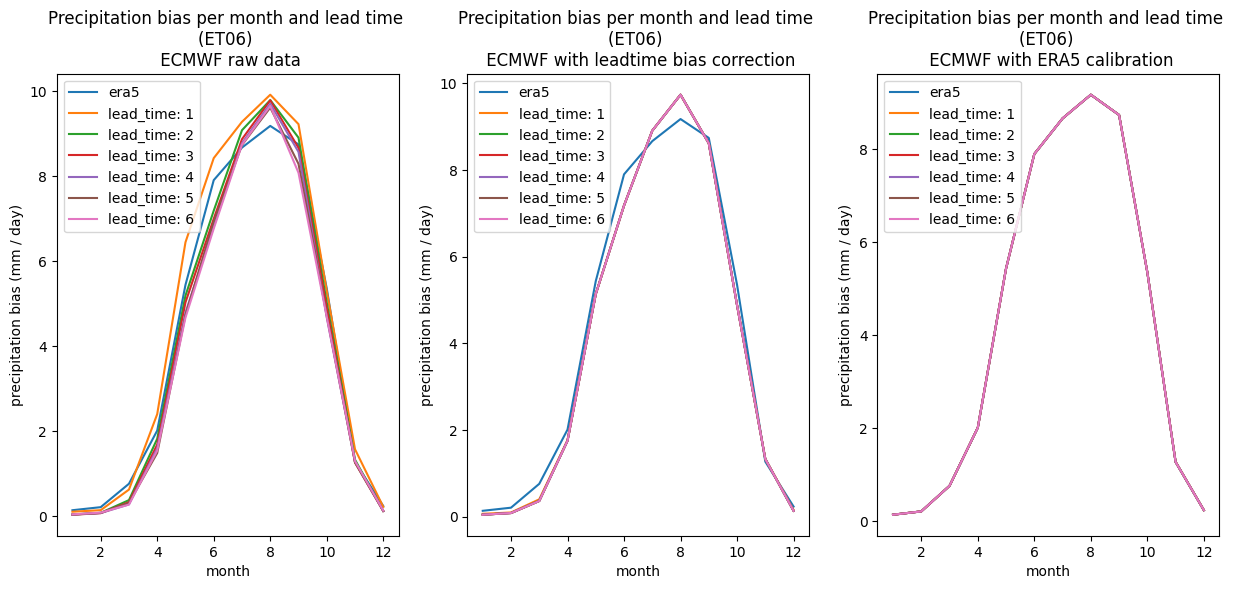

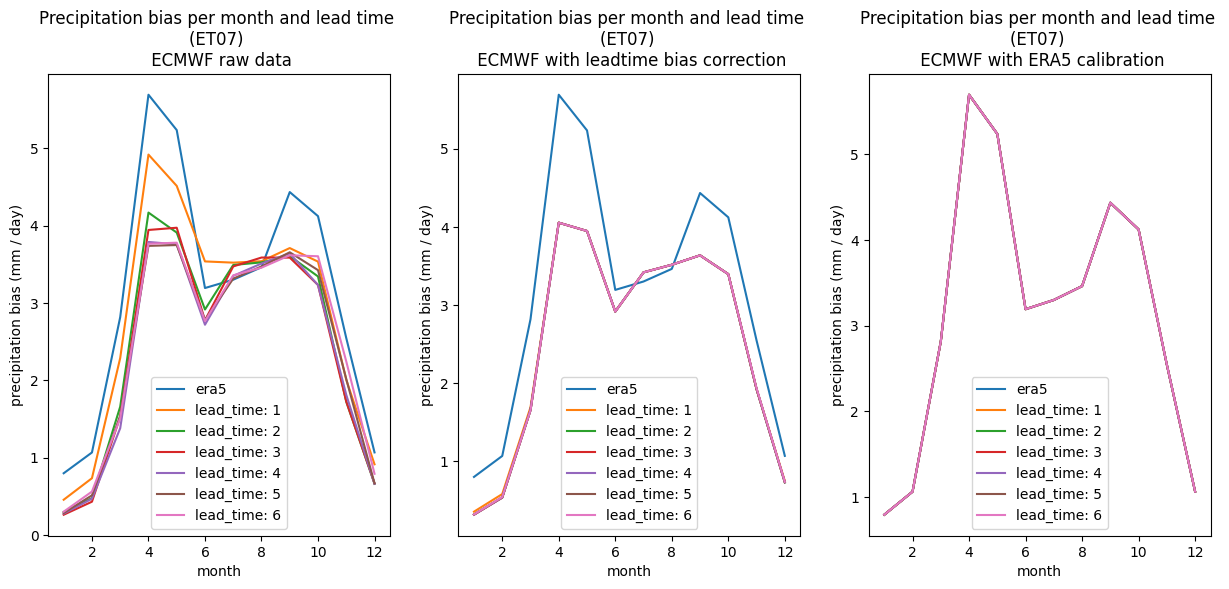

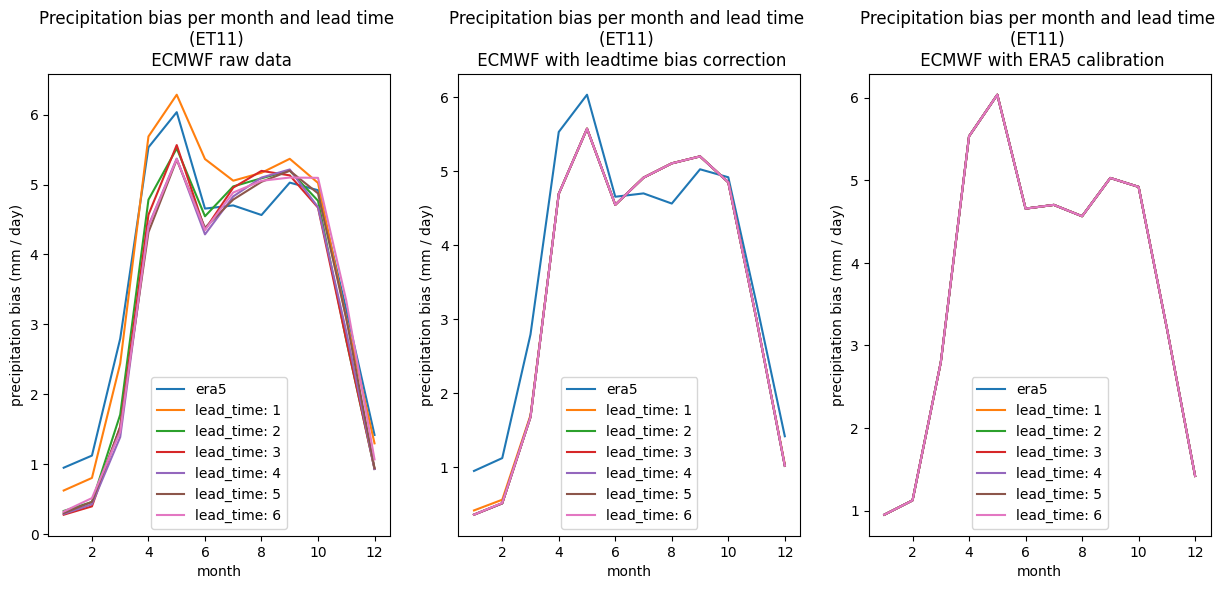

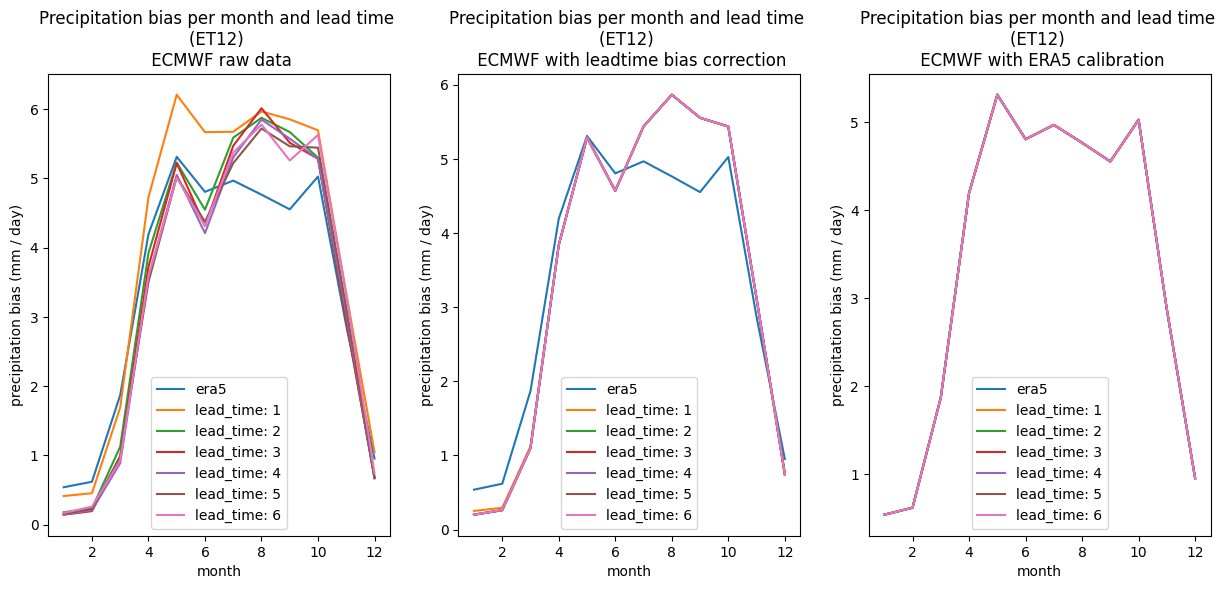

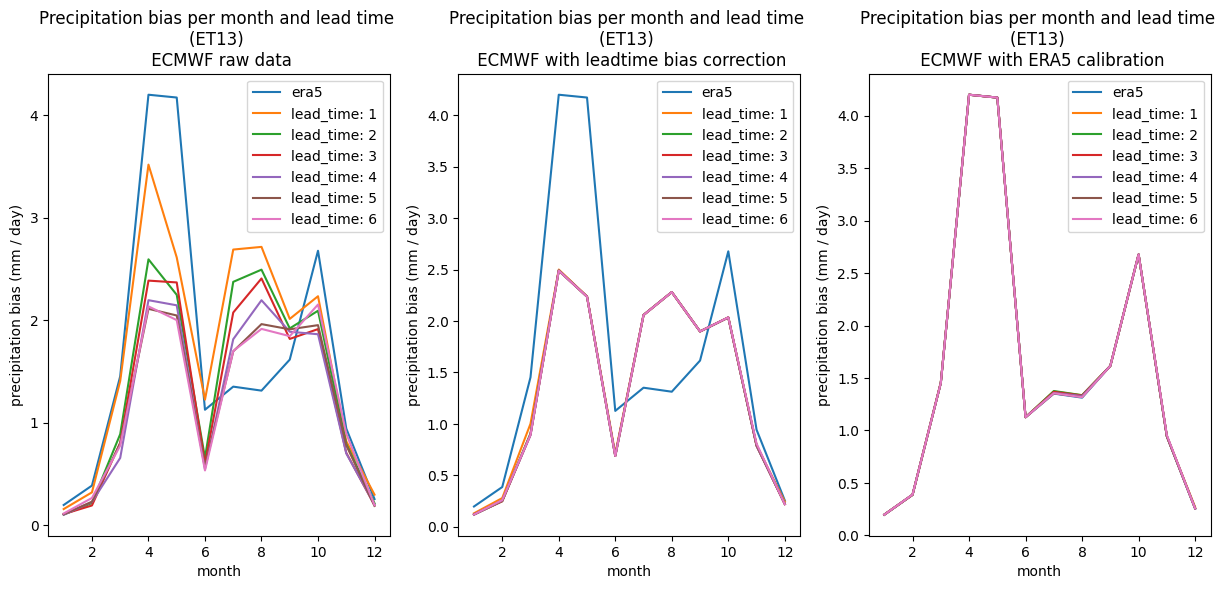

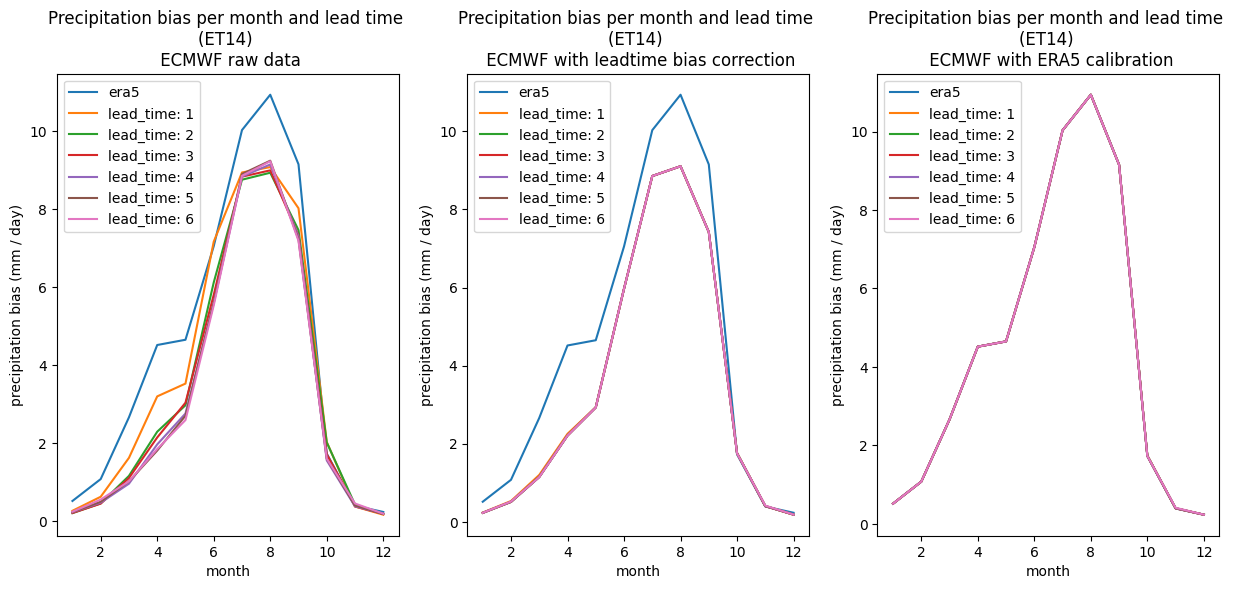

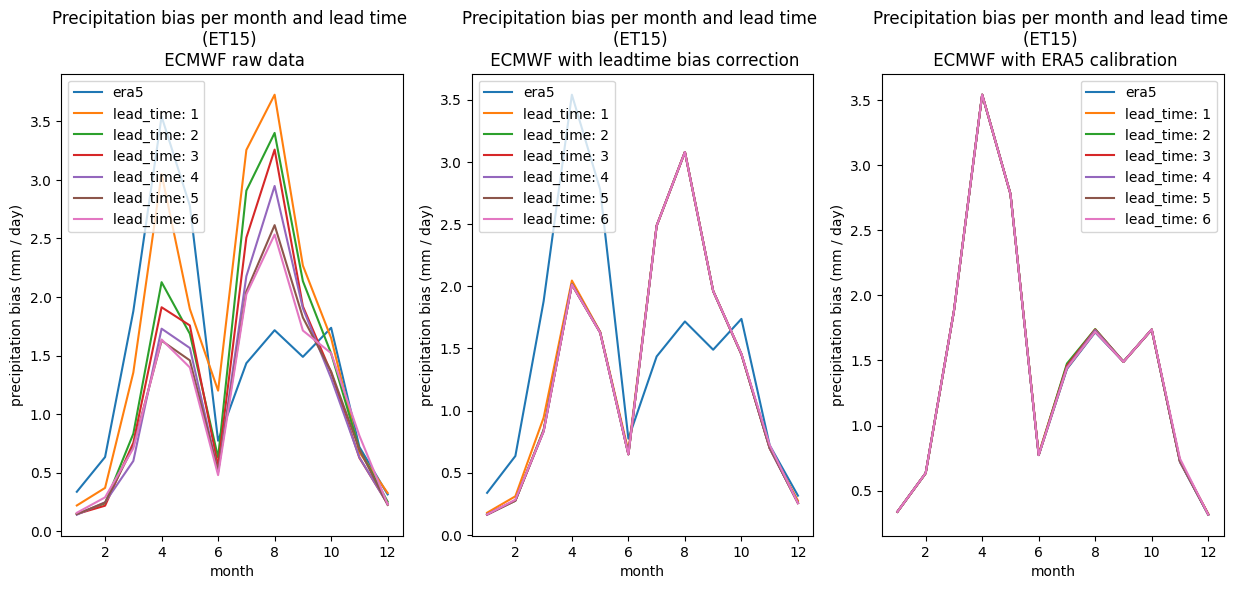

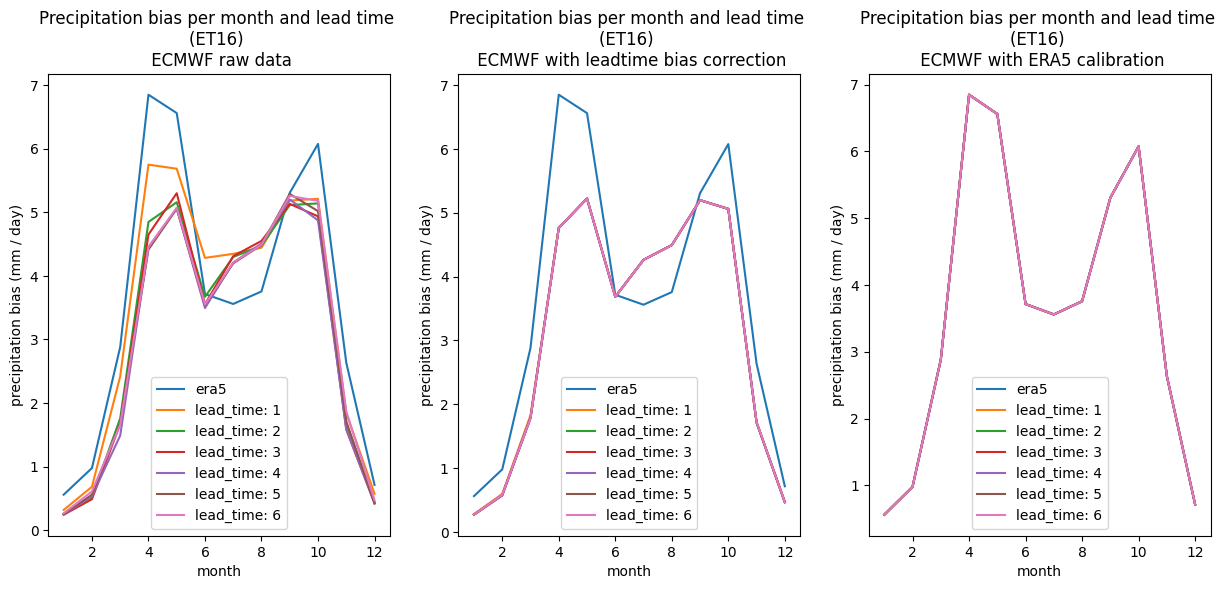

In [15]:
for adm_pcode in ecmwf_adm_df["adm_pcode"].unique():

    ecmwf_plot_df, era5_plot_df = prepare_climatology(
        ecmwf_adm_df[ecmwf_adm_df["adm_pcode"] == adm_pcode],
        era5_adm_df[era5_adm_df["adm_pcode"] == adm_pcode],
    )
    plot_climatology(ecmwf_plot_df, era5_plot_df, scope_text=adm_pcode)

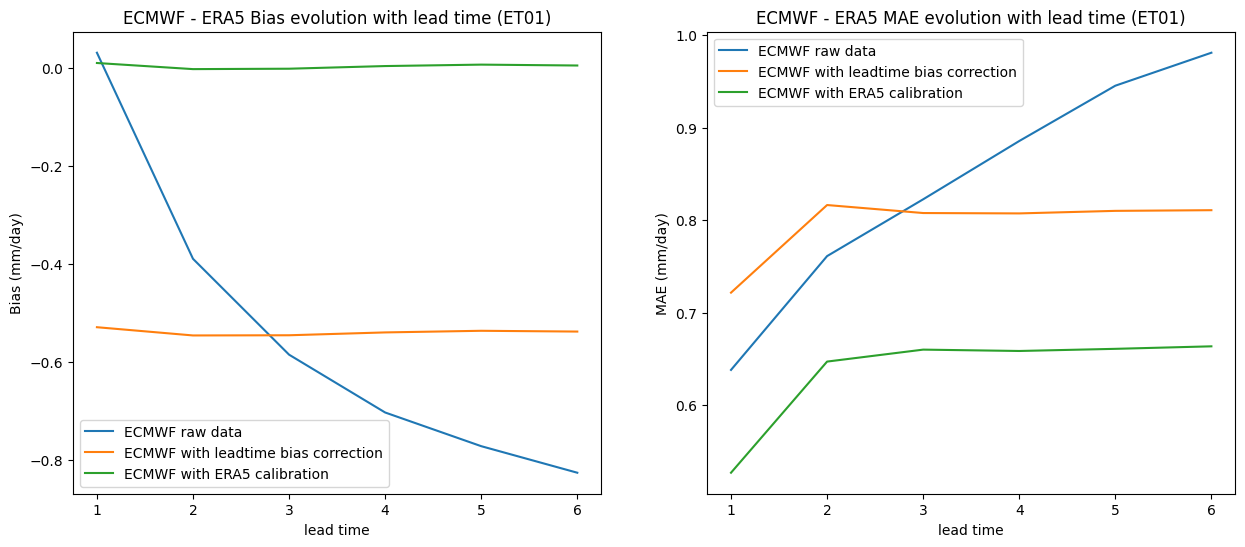

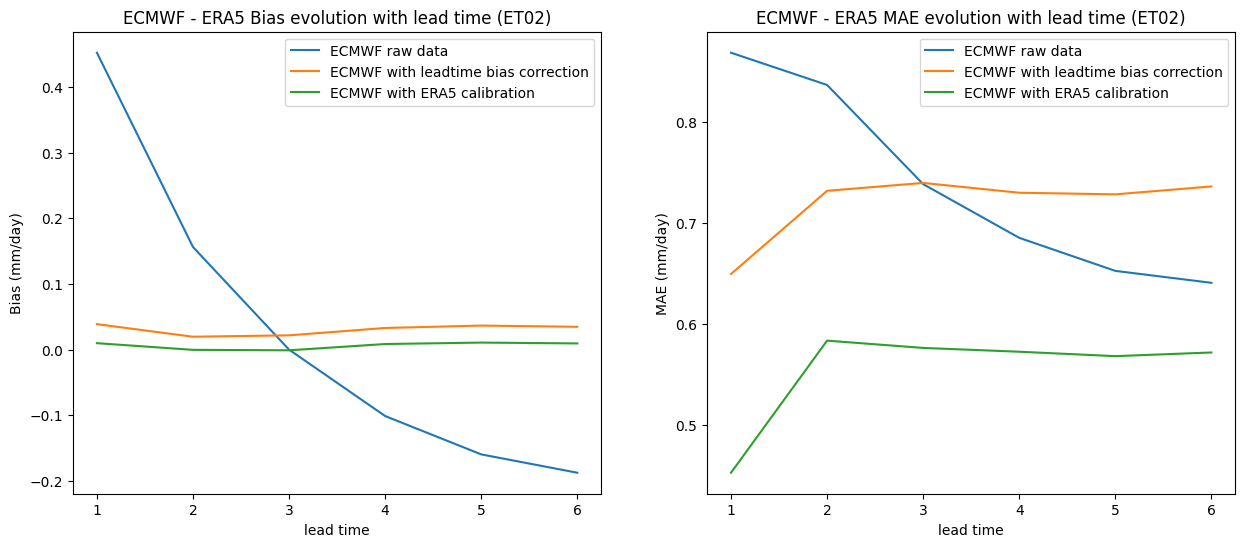

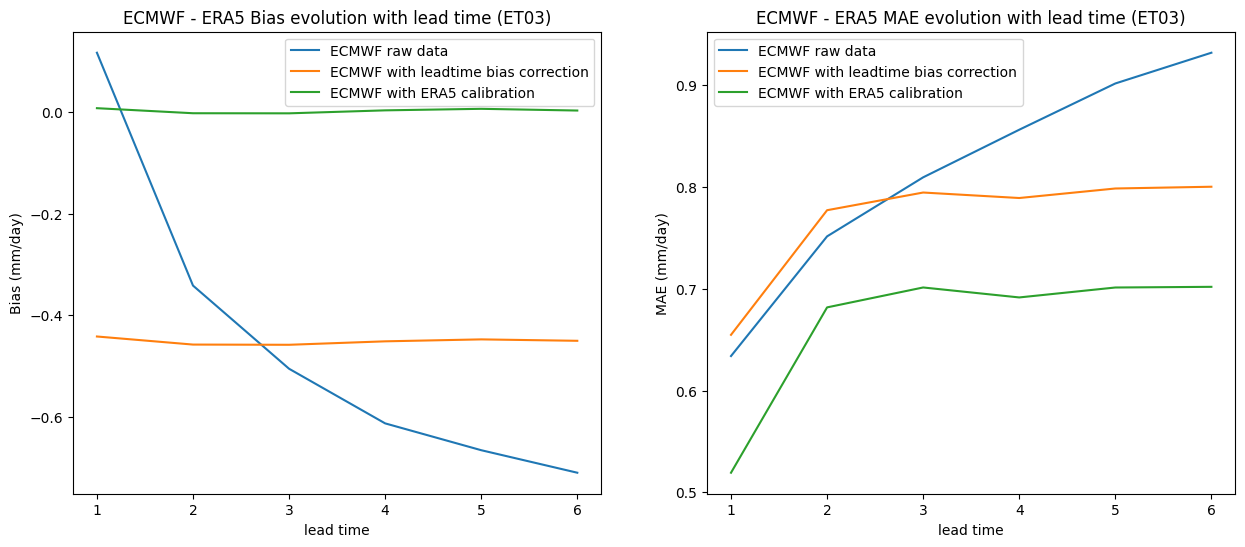

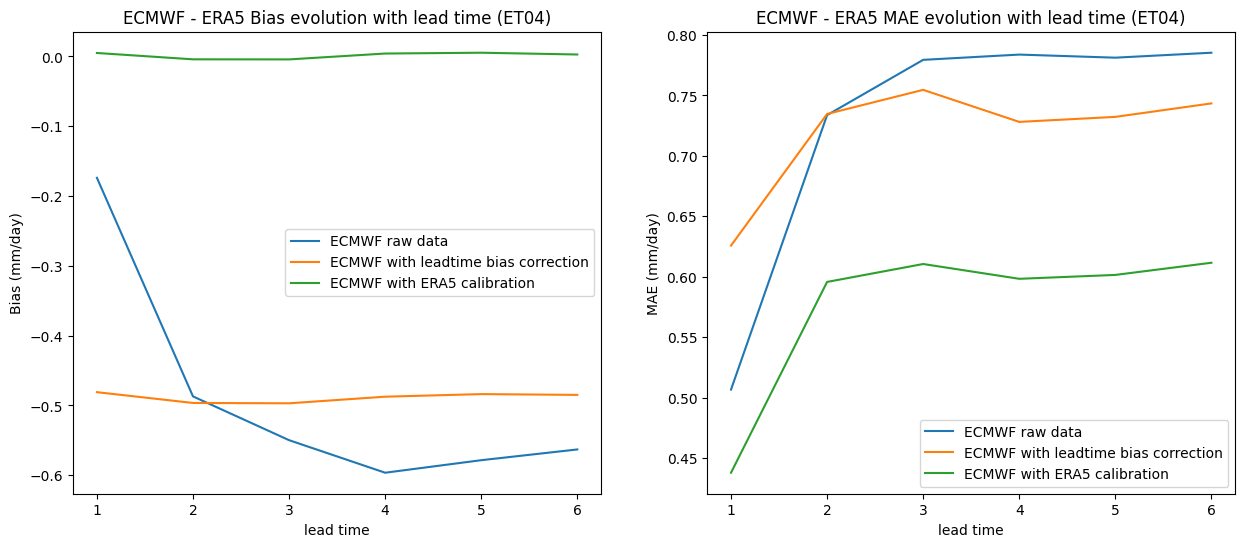

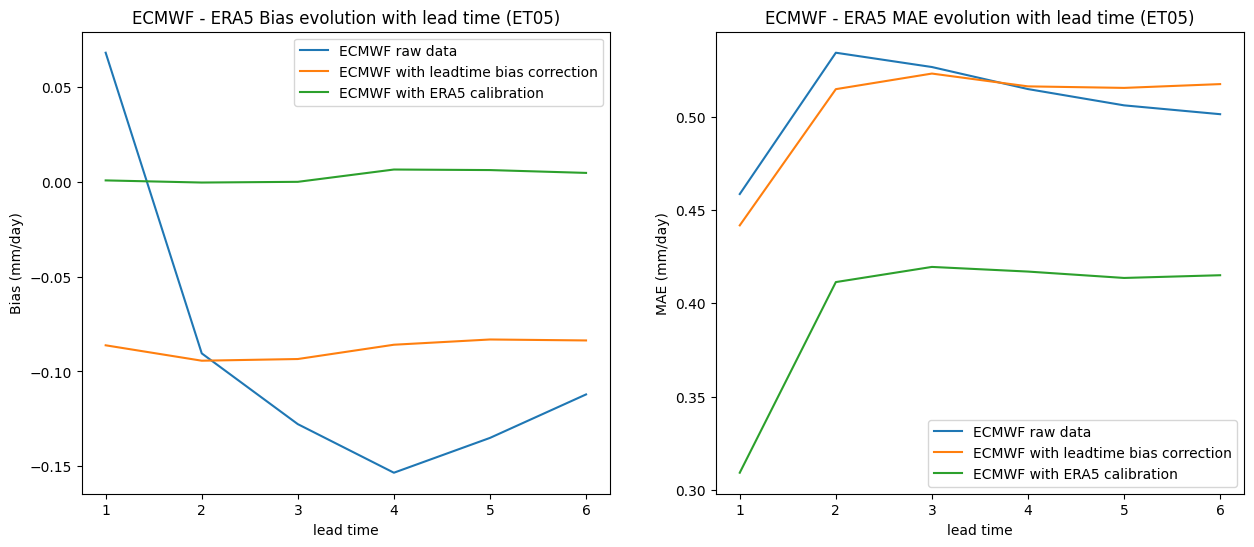

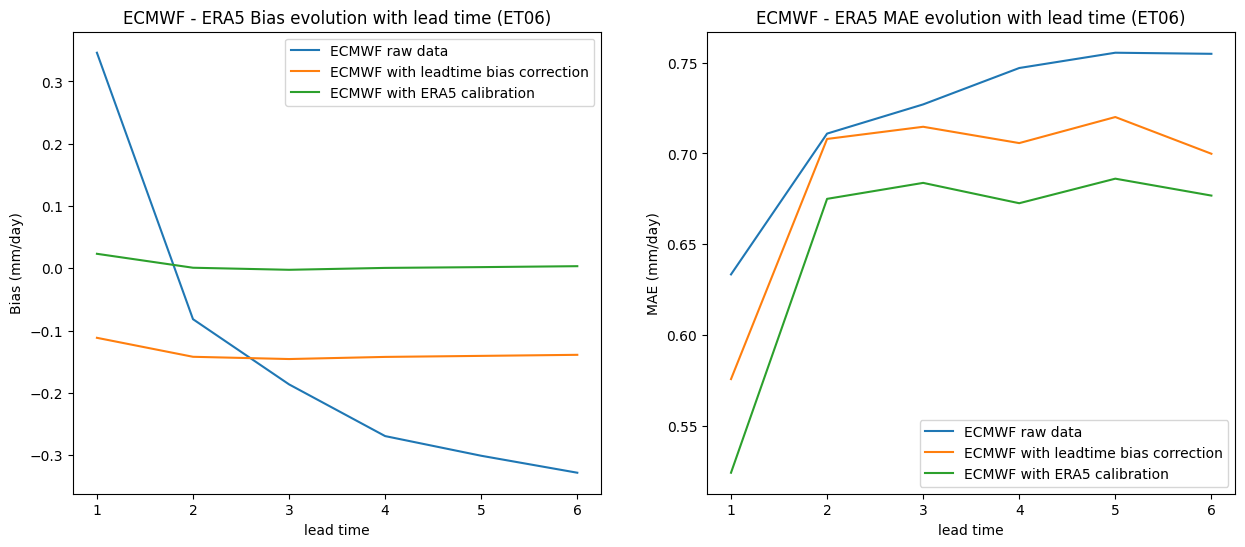

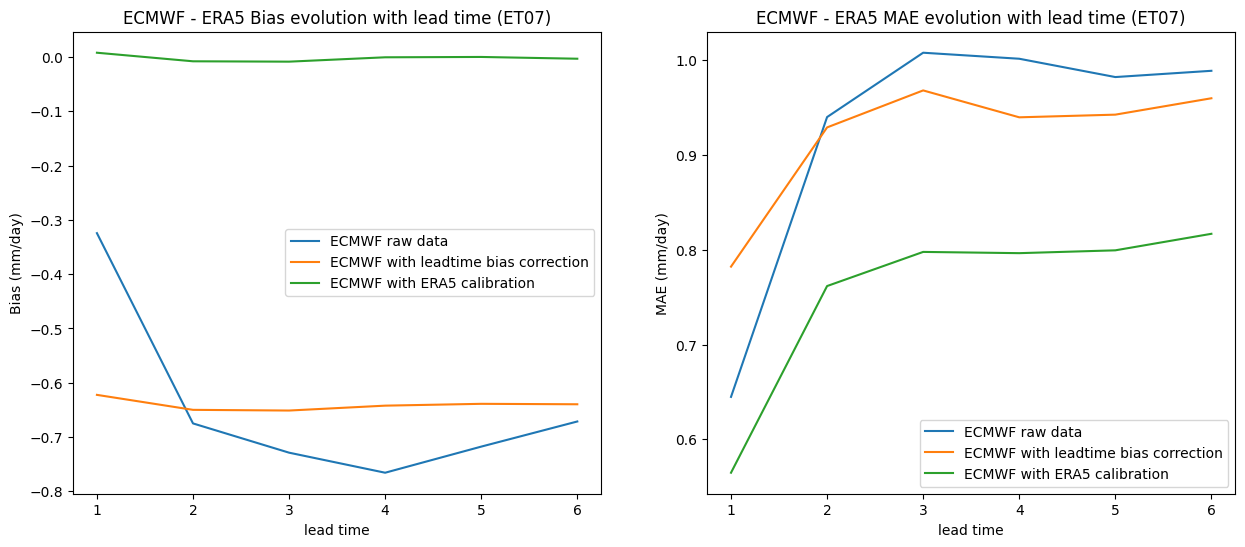

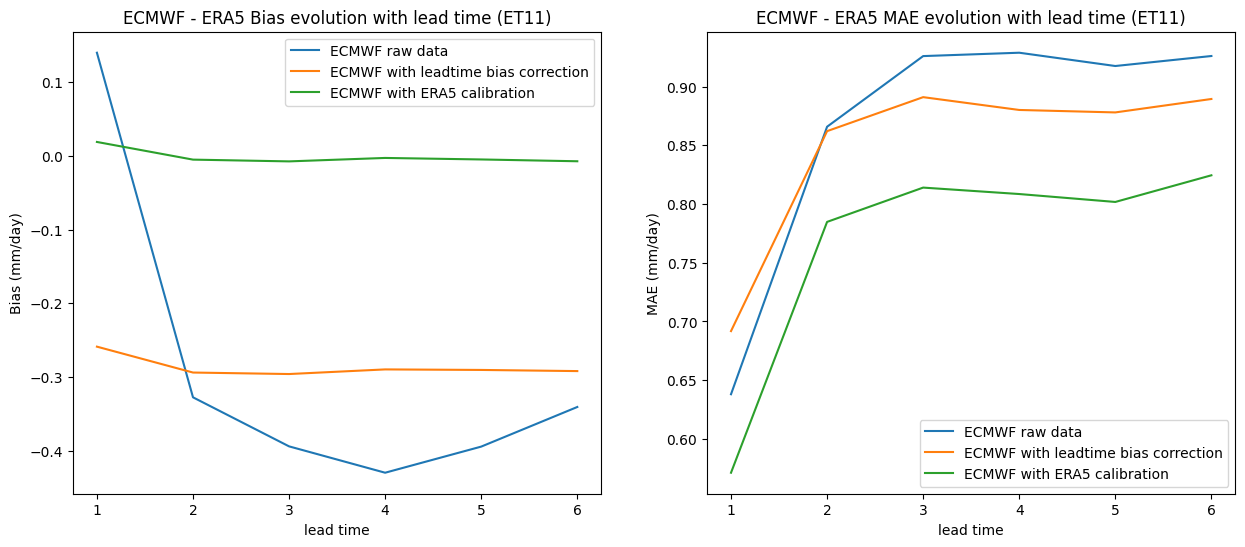

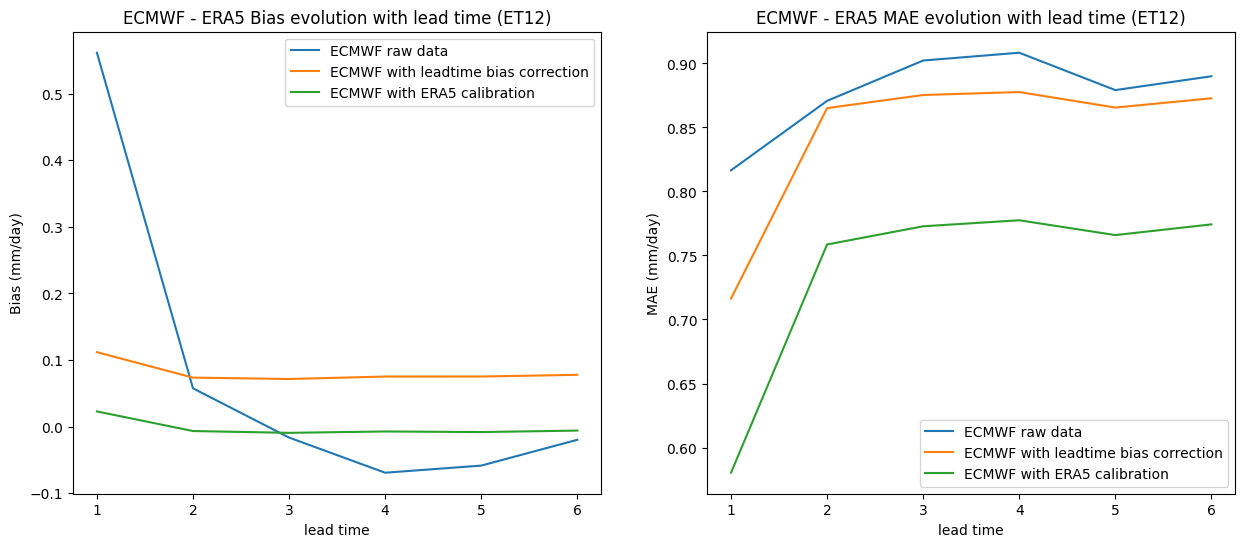

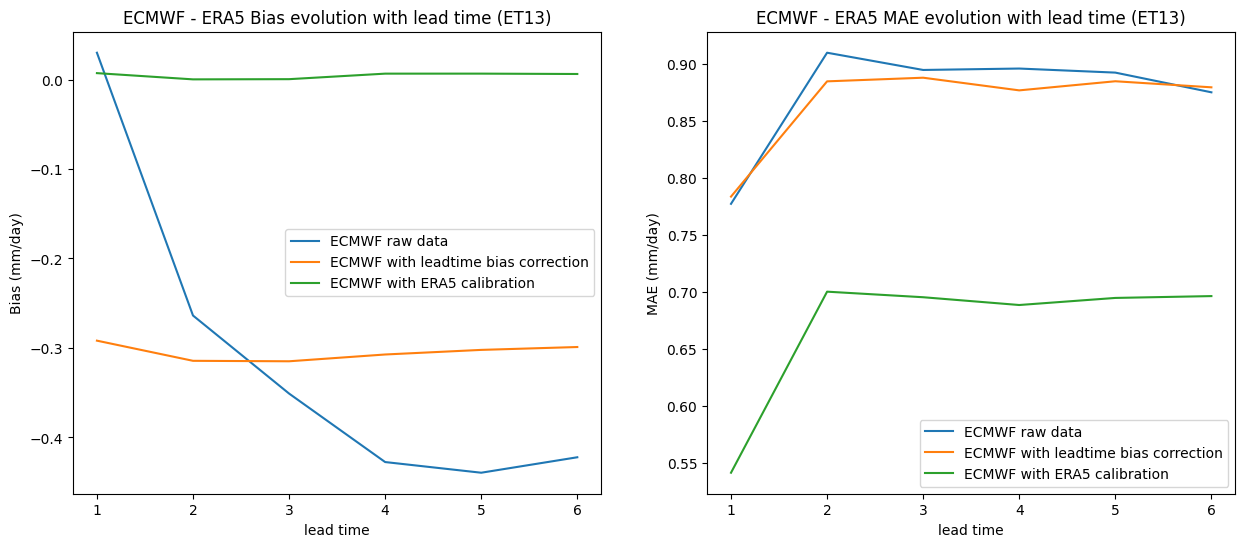

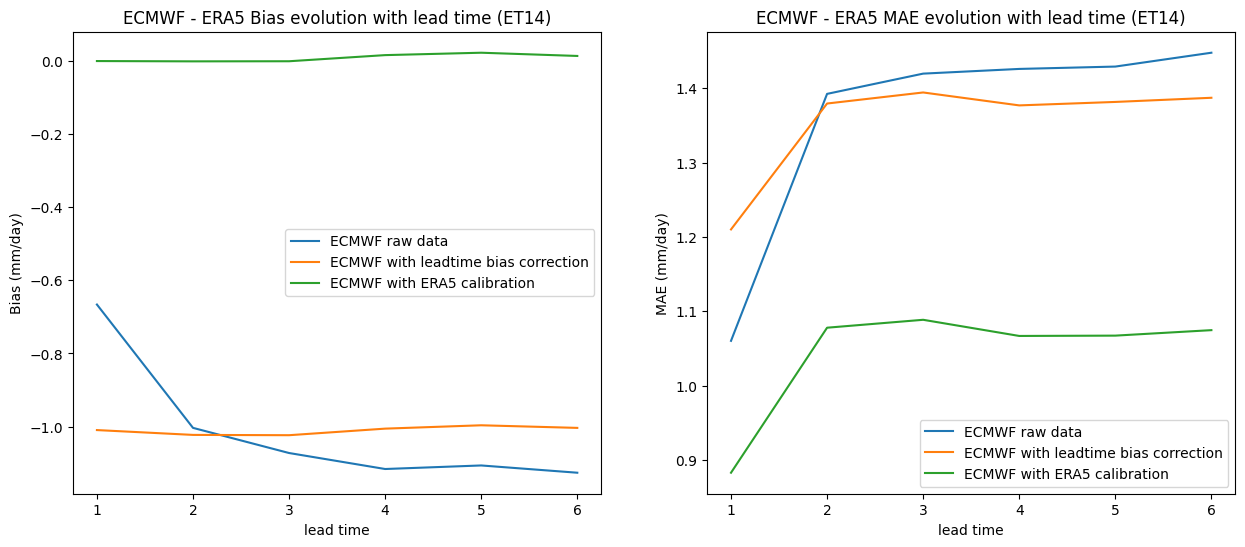

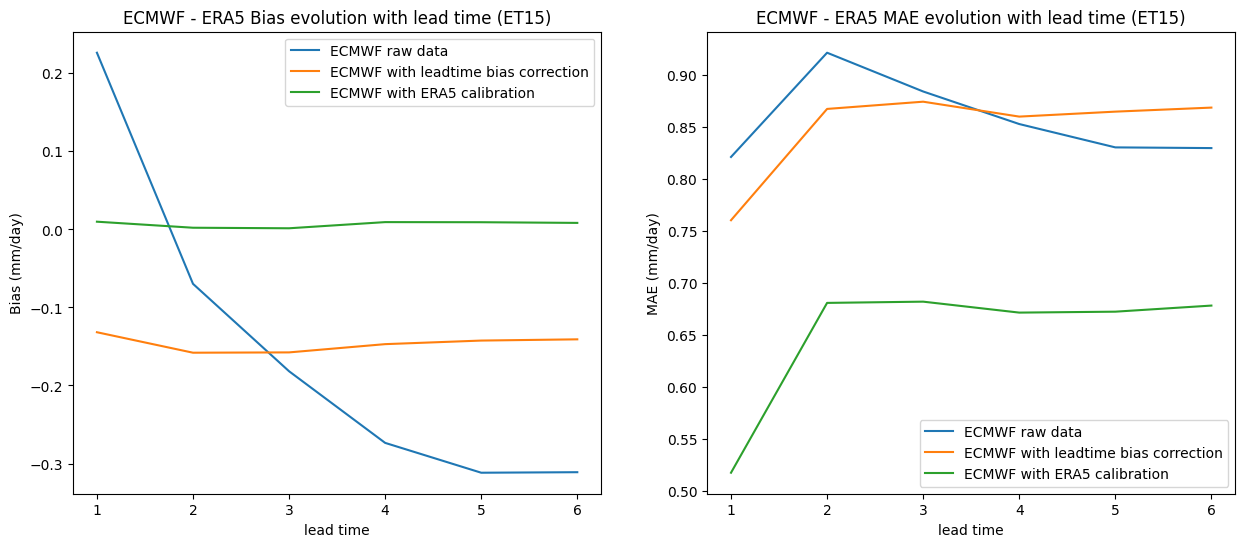

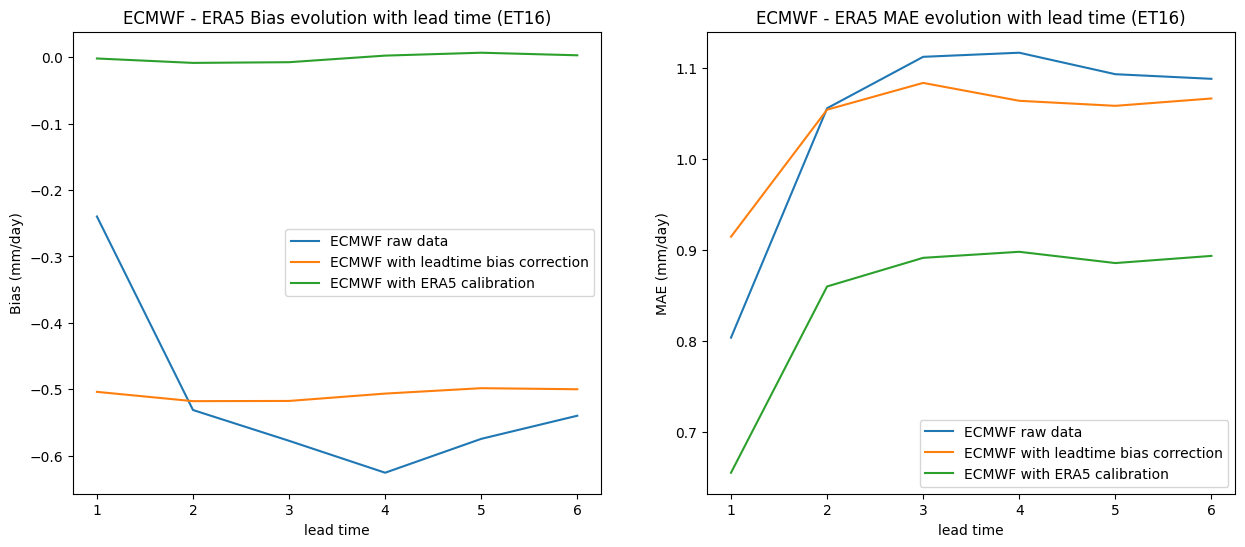

In [16]:
for adm_pcode in ecmwf_adm_df["adm_pcode"].unique():
    plot_df = prepare_leadtime_month_dependency(
        ecmwf_adm_df[ecmwf_adm_df["adm_pcode"] == adm_pcode],
        era5_adm_df[era5_adm_df["adm_pcode"] == adm_pcode],
        month_range,
    )
    plot_leadtime_month_dependency(plot_df, scope_text=adm_pcode)

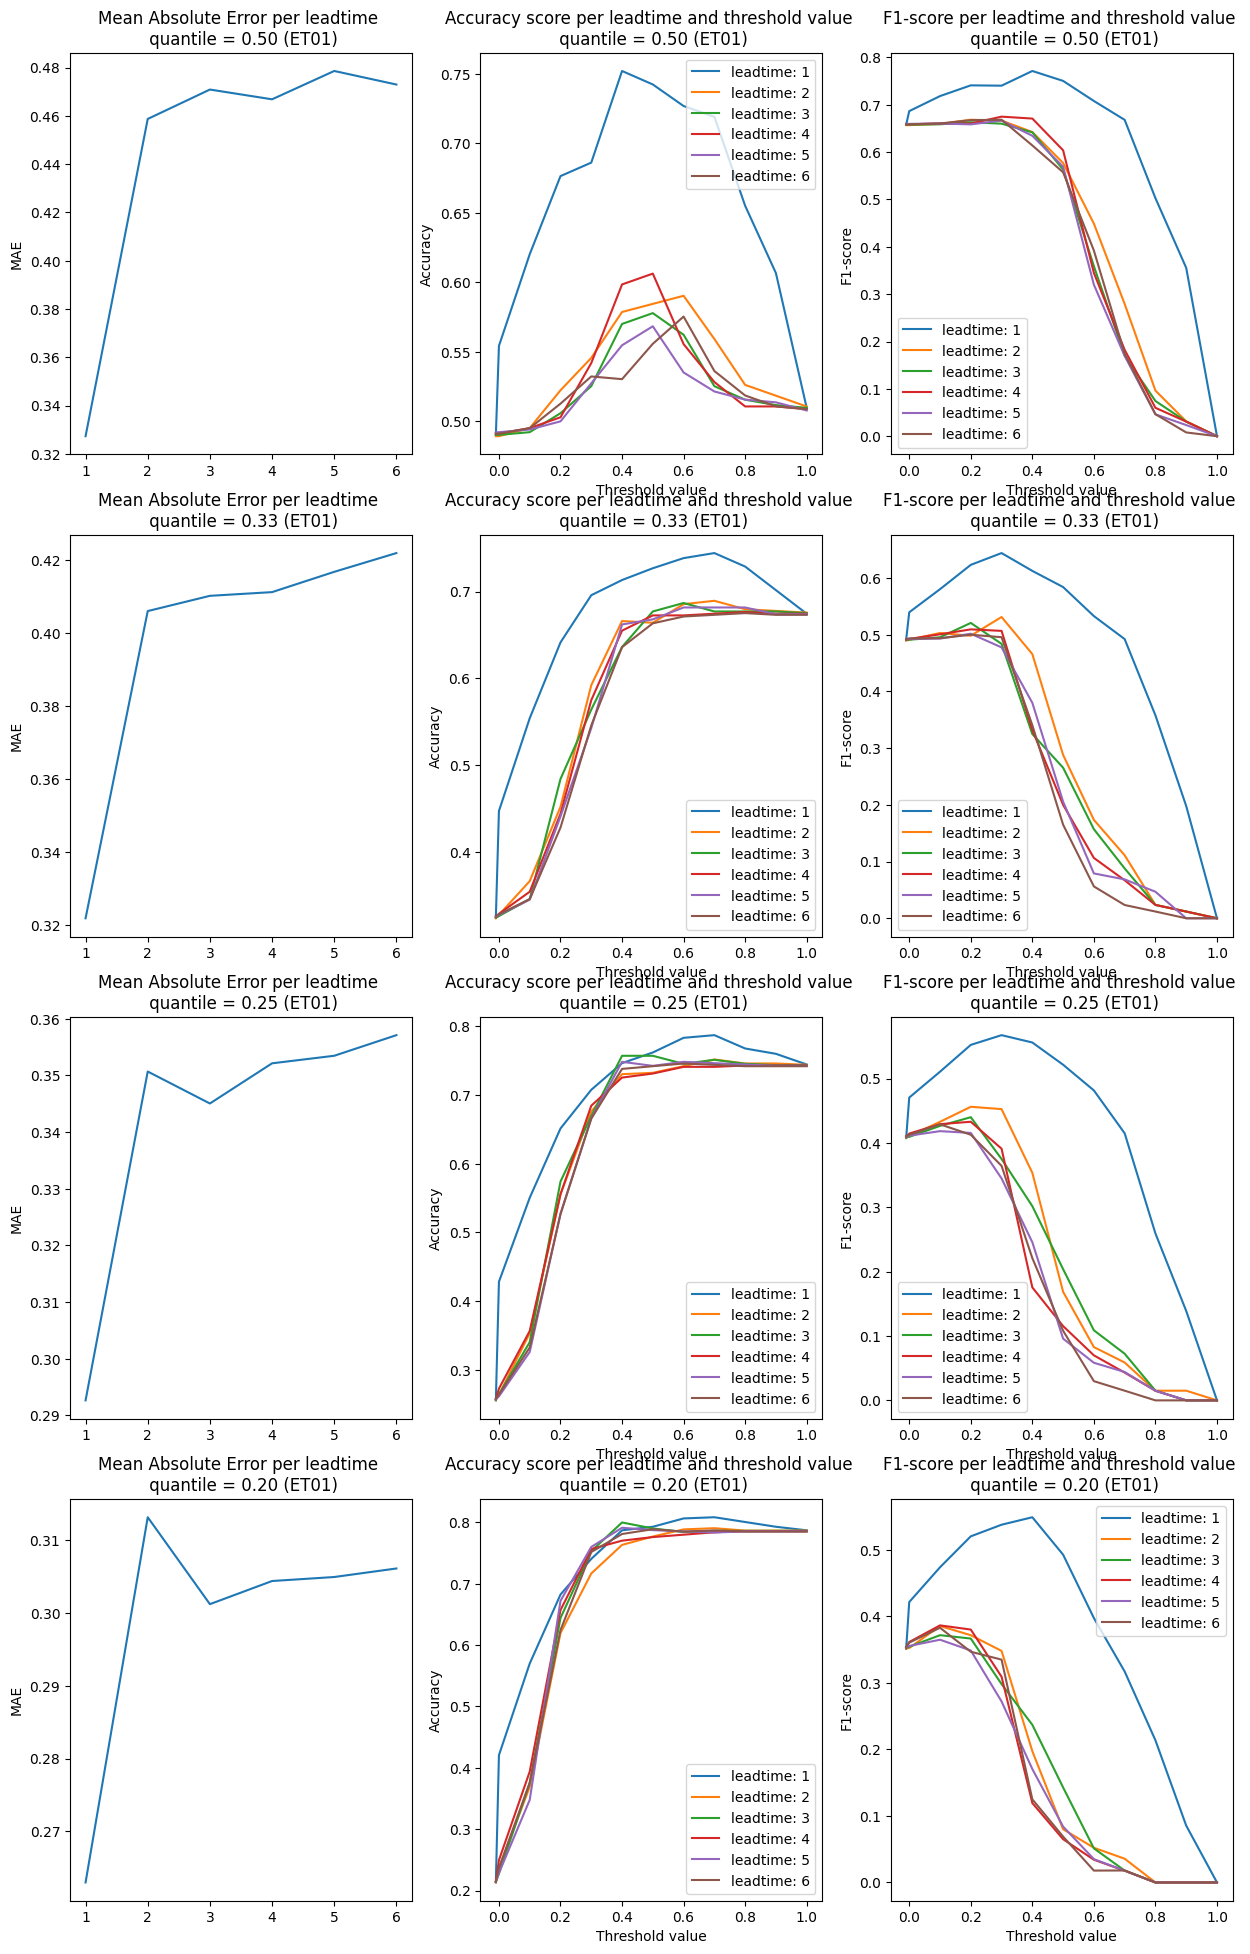

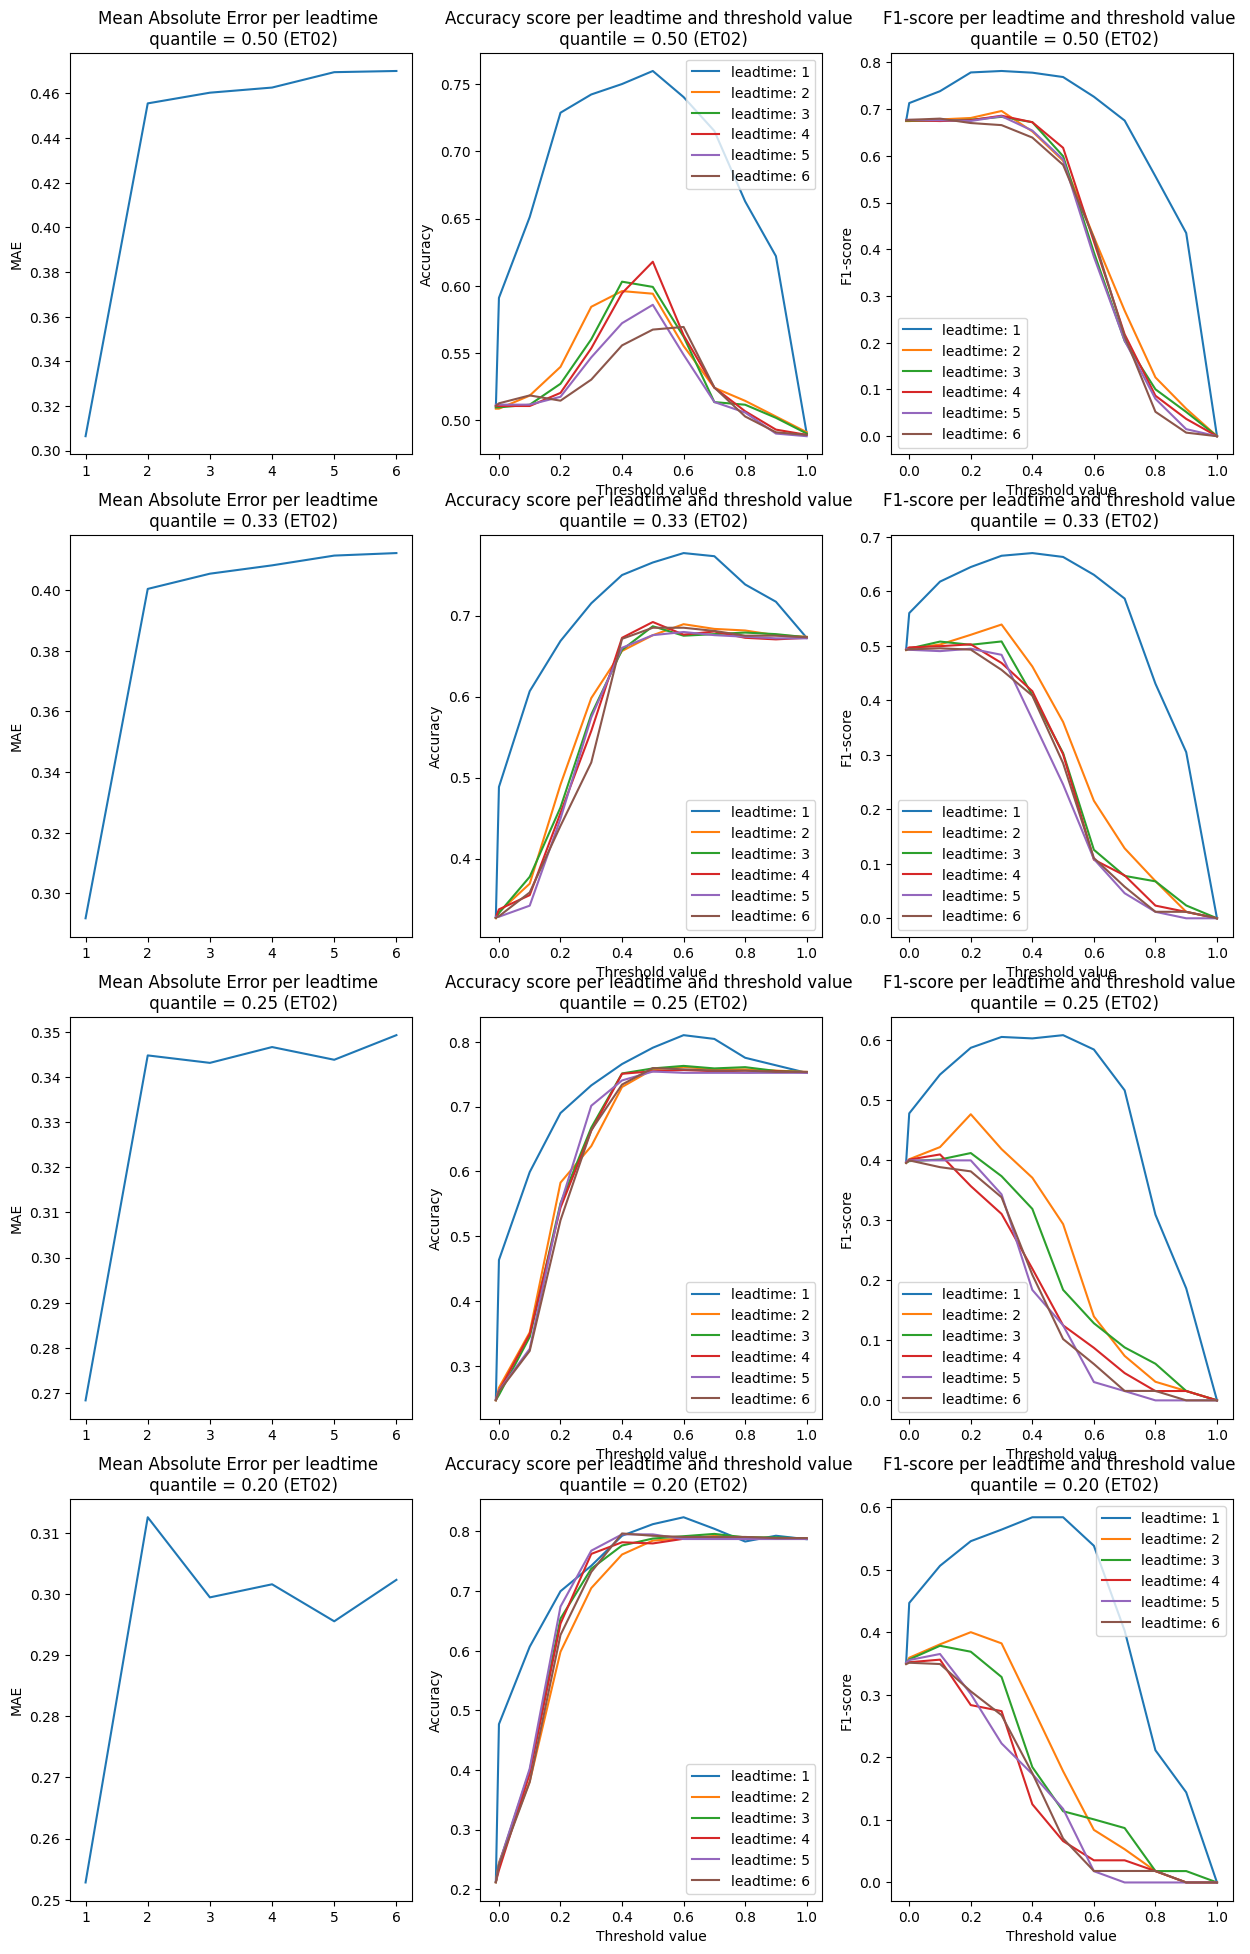

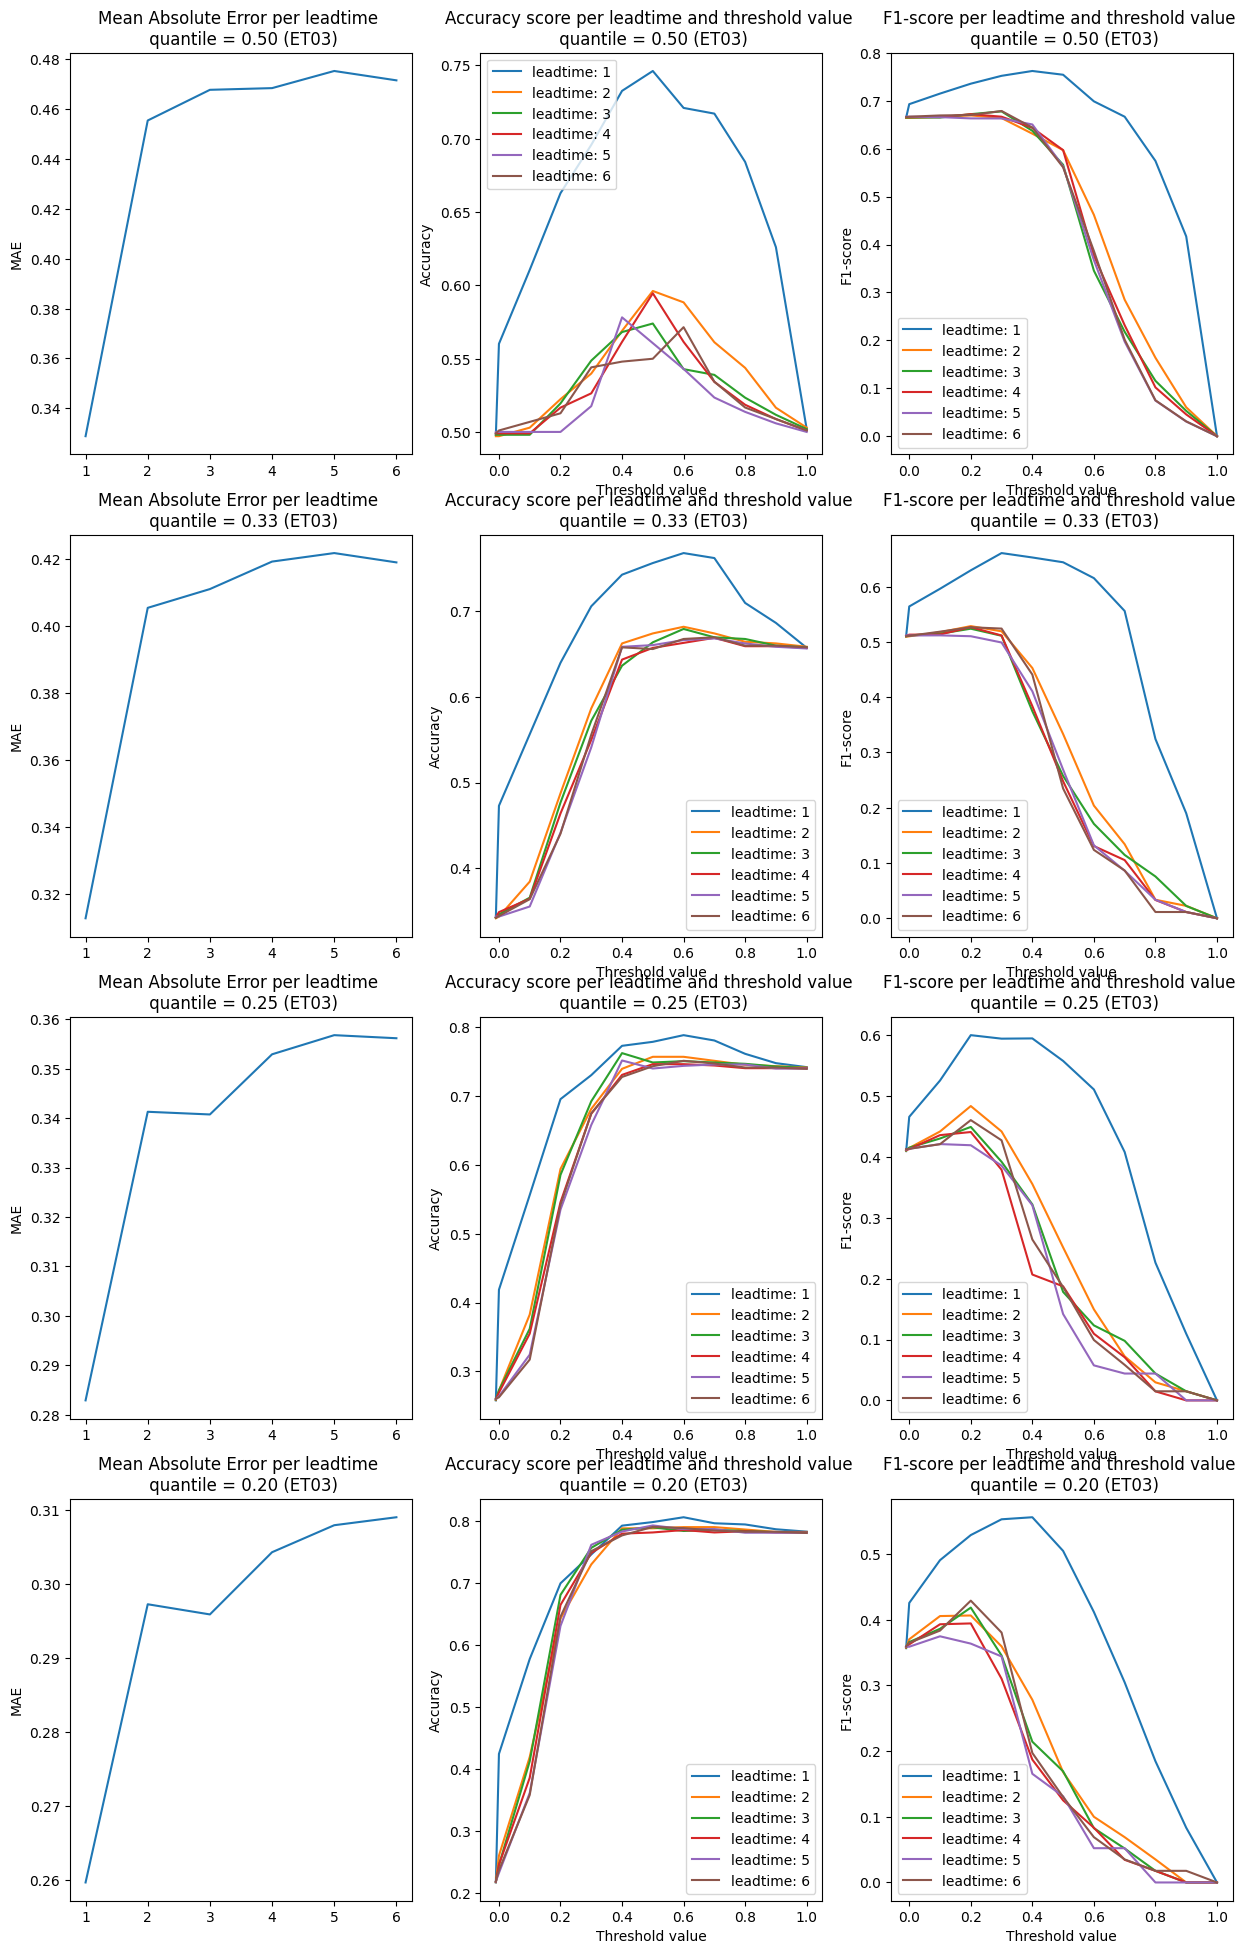

In [ ]:
for adm_pcode in ecmwf_adm_quantile_df["adm_pcode"].unique():
    plot_performance_analysis(
        ecmwf_adm_quantile_df[ecmwf_adm_quantile_df["adm_pcode"] == adm_pcode],
        era5_adm_quantile_df[era5_adm_quantile_df["adm_pcode"] == adm_pcode],
        quantile_value_list,
        month_range,
        scope_text=adm_pcode,
    )

In [ ]:
for adm_pcode in ecmwf_adm_quantile_df["adm_pcode"].unique():
    plot_roc_auc_analysis(
        ecmwf_adm_quantile_df[ecmwf_adm_quantile_df["adm_pcode"] == adm_pcode],
        era5_adm_quantile_df[era5_adm_quantile_df["adm_pcode"] == adm_pcode],
        quantile_value_list,
        month_range,
        scope_text=adm_pcode,
    )